# Final Project

For the final project, I'm selecting the first option:  
1. Using aggregated data, produce forecasts for four (4) different metrics. You can
use any of the metrics for this option. You will need to accurately calculate
the national aggregates for the metrics - if using non-count metrics, you’ll
need to calculate weighted averages.

## Importing the libraries

In [1]:
#importing the libraries
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))
suppressMessages(library(prophet))
suppressMessages(library(ggplot2))
suppressMessages(library(forecast))

In [2]:
#setting for plot dimensions
options(repr.plot.width=12, repr.plot.height=8)

## Import the housing data

In [3]:
df <- read.csv('monthly_housing_inventory.csv')
df %>% dim()

Warning message in file(file, "rt"):
"cannot open file 'monthly_housing_inventory.csv': No such file or directory"


ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
df %>% distinct() %>% dim()

[1] 288385     10

In [ ]:
df %>% head()

month_date_yyyymm county_name median_listing_price active_listing_count
1 202403            hartley, tx 425000                12                 
2 202403            rock, mn    309900                21                 
3 202403            carter, ok  199000               165                 
4 202403            mckean, pa  169000                48                 
5 202403            etowah, al  248950               236                 
6 202403            dawson, ga  679450               135                 
  new_listing_count pending_listing_count median_listing_price_per_square_foot
1   0                1                    289                                 
2   8               13                    136                                 
3  56               59                    127                                 
4  12               25                     89                                 
5 128               67                    124                                 
6  76               80                    227                                 
  median_square_feet average_listing_price total_listing_count
1 3024               444336                 12                
2 2016               397205                 35                
3 1633               306719                222                
4 1898               187270                 71                
5 1894               296370                303                
6 2802               814852                211

## Extract county, state, and create date variable
The `county_name` contains the `county` and `state`. Use `regex` to extract those into separate fields. Convert the `month_date_yyyymm` from an integer to a `monthly date`.


In [ ]:
df <-  df %>% 
mutate(county = str_extract(county_name, '^(.*)?, ([a-z]{2})$', group=1)) %>%
mutate(state = str_extract(county_name, '^(.*)?, ([a-z]{2})$', group=2)) %>%
mutate(month_date = tsibble::yearmonth(as.character(month_date_yyyymm), '%Y%m'))

df %>% head()

month_date_yyyymm county_name median_listing_price active_listing_count
1 202403            hartley, tx 425000                12                 
2 202403            rock, mn    309900                21                 
3 202403            carter, ok  199000               165                 
4 202403            mckean, pa  169000                48                 
5 202403            etowah, al  248950               236                 
6 202403            dawson, ga  679450               135                 
  new_listing_count pending_listing_count median_listing_price_per_square_foot
1   0                1                    289                                 
2   8               13                    136                                 
3  56               59                    127                                 
4  12               25                     89                                 
5 128               67                    124                                 
6  76               80                    227                                 
  median_square_feet average_listing_price total_listing_count county  state
1 3024               444336                 12                 hartley tx   
2 2016               397205                 35                 rock    mn   
3 1633               306719                222                 carter  ok   
4 1898               187270                 71                 mckean  pa   
5 1894               296370                303                 etowah  al   
6 2802               814852                211                 dawson  ga   
  month_date
1 2024 Mar  
2 2024 Mar  
3 2024 Mar  
4 2024 Mar  
5 2024 Mar  
6 2024 Mar

In [ ]:
df_ts <- df %>% as_tsibble(index=month_date, key=c(state, county))

In [ ]:
df_ts %>% head(5)

month_date_yyyymm county_name        median_listing_price
1 201607            aleutians east, ak 485000              
2 201608            aleutians east, ak 342250              
3 201609            aleutians east, ak 342250              
4 201610            aleutians east, ak 199500              
5 201611            aleutians east, ak 342250              
  active_listing_count new_listing_count pending_listing_count
1 3                    0                 NA                   
2 4                    0                 NA                   
3 4                    0                 NA                   
4 4                    0                 NA                   
5 4                    0                 NA                   
  median_listing_price_per_square_foot median_square_feet average_listing_price
1  93                                  4100               394833               
2  87                                  3285               308350               
3  87                                  3285               307350               
4  93                                  2469               281880               
5 106                                  3285               336125               
  total_listing_count county         state month_date
1 3                   aleutians east ak    2016 Jul  
2 4                   aleutians east ak    2016 Aug  
3 4                   aleutians east ak    2016 Sep  
4 4                   aleutians east ak    2016 Oct  
5 4                   aleutians east ak    2016 Nov

### Aggregating the data

In [ ]:
df_ts %>%
fabletools::aggregate_key(
    state / county,
    total_listings=sum(total_listing_count),
    new_listings=sum(new_listing_count,na.rm=TRUE)
) %>%
head()

month_date state        county       total_listings new_listings
1 2016 Jul   <aggregated> <aggregated> 1873362        497388      
2 2016 Aug   <aggregated> <aggregated> 1845212        464934      
3 2016 Sep   <aggregated> <aggregated> 1809143        444898      
4 2016 Oct   <aggregated> <aggregated> 1753435        410322      
5 2016 Nov   <aggregated> <aggregated> 1664952        352640      
6 2016 Dec   <aggregated> <aggregated> 1522590        266860

In [ ]:
#Aggregating all the columns counts with sum and non-counts with the weighted average.

df_ts_aggregated <- df %>%
mutate(feet = median_square_feet * total_listing_count) %>%
mutate(median_price = median_listing_price * total_listing_count) %>%
mutate(avg_price = average_listing_price * total_listing_count) %>%
mutate(median_price_per_sqft = median_listing_price_per_square_foot * total_listing_count) %>%
group_by(month_date_yyyymm) %>%
summarise(
    total_listings = sum(total_listing_count, na.rm = TRUE),
    new_listings = sum(new_listing_count, na.rm = TRUE),
    feet = sum(feet, na.rm=TRUE),
    median_price = sum(median_price, na.rm=TRUE),
    avg_price = sum(avg_price, na.rm=TRUE),
    median_price_per_sqft = sum(median_price_per_sqft, na.rm= TRUE)
, .groups='drop') %>%
mutate(wgt_median_square_feet = feet / total_listings) %>%
mutate(wgt_median_price = median_price / total_listings) %>%
mutate(wgt_avg_price = avg_price / total_listings) %>%
mutate(wgt_median_price_per_sqft = median_price_per_sqft / total_listings) %>%

mutate(month_date = tsibble::yearmonth(as.character(month_date_yyyymm), '%Y%m')) %>%
select(-feet, -month_date_yyyymm, -median_price, -avg_price, -median_price_per_sqft ) %>%
as_tsibble(index=month_date) 

df_ts_aggregated%>%head(5)

total_listings new_listings wgt_median_square_feet wgt_median_price
1 1873362        497388       1984.003               300024.4        
2 1845212        464934       1974.786               296973.9        
3 1809143        444898       1970.087               296262.8        
4 1753435        410322       1964.404               297607.5        
5 1664952        352640       1956.831               296985.0        
  wgt_avg_price wgt_median_price_per_sqft month_date
1 454074.5      157.2850                  2016 Jul  
2 449940.7      156.2378                  2016 Aug  
3 450290.5      156.9382                  2016 Sep  
4 455096.5      158.1429                  2016 Oct  
5 457459.6      158.2808                  2016 Nov

In [ ]:
df_ts_aggregated %>% dim()

[1] 93  7

In [ ]:
#Checking for any gaps
df_ts_aggregated %>% scan_gaps() %>% head()

month_date

From the above we can see that there are no gaps in the aggregated data. Let's check for null values.

In [ ]:
sum(is.na(df_ts_aggregated))

[1] 0

There are no null values. Lets proceed for visualizations.  
Out of the aggregated 6 metrics, I'm selecting Total_listings(total_listing_count), New_listings(new_listing_count), Weighted_Median_Square_feet(median_square_feet), Weighted_Median_Price_per_square_feet(median_listing_price_per_square_foot).

## Visualizations and Analysis

### Total Listings

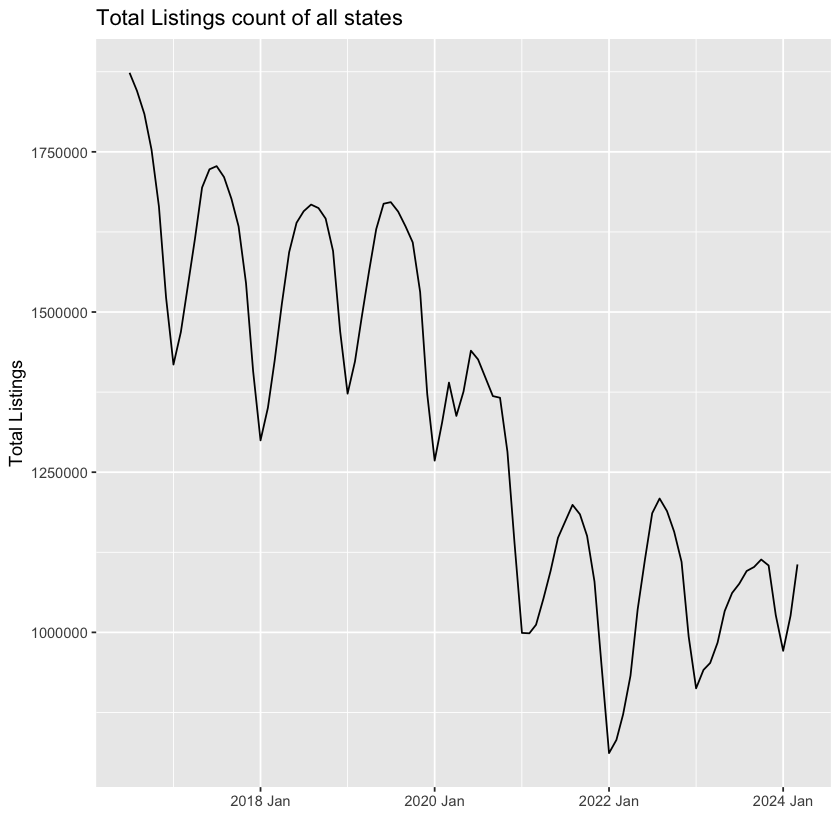

In [ ]:
# Plotting total listings over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = total_listings)) +
  geom_line() +
  labs(title = 'Total Listings count of all states', x = '', y = 'Total Listings')


From the above plot, the total listings count is decresing from year to year and we can see the seasonal patterns.

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


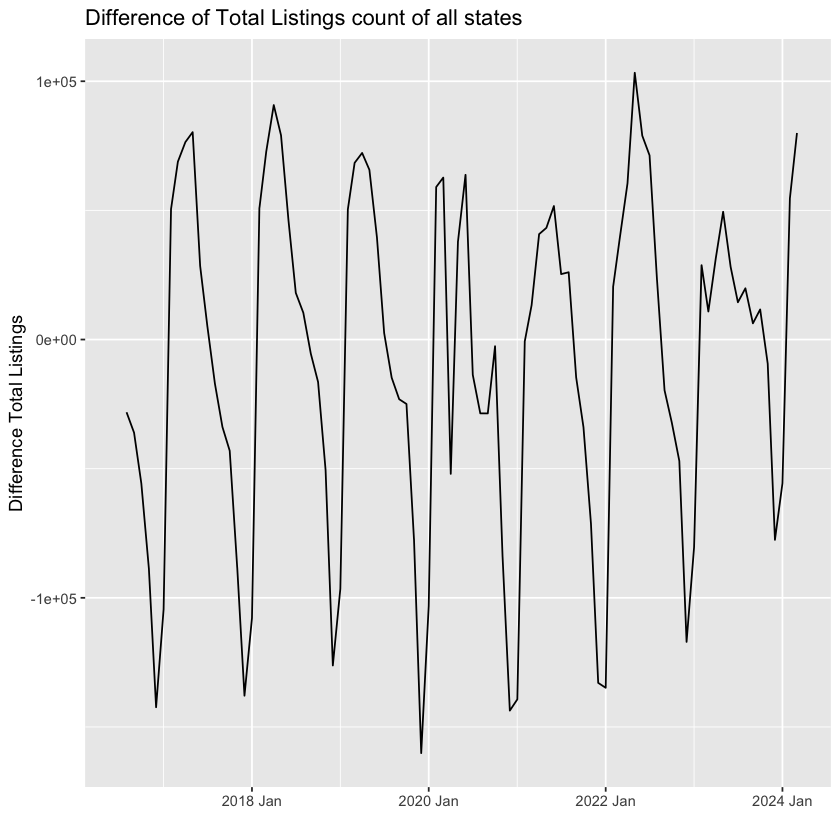

In [ ]:
# Plotting difference of total listings over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(total_listings))) +
  geom_line() +
  labs(title = 'Difference of Total Listings count of all states', x = '', y = 'Difference Total Listings')

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


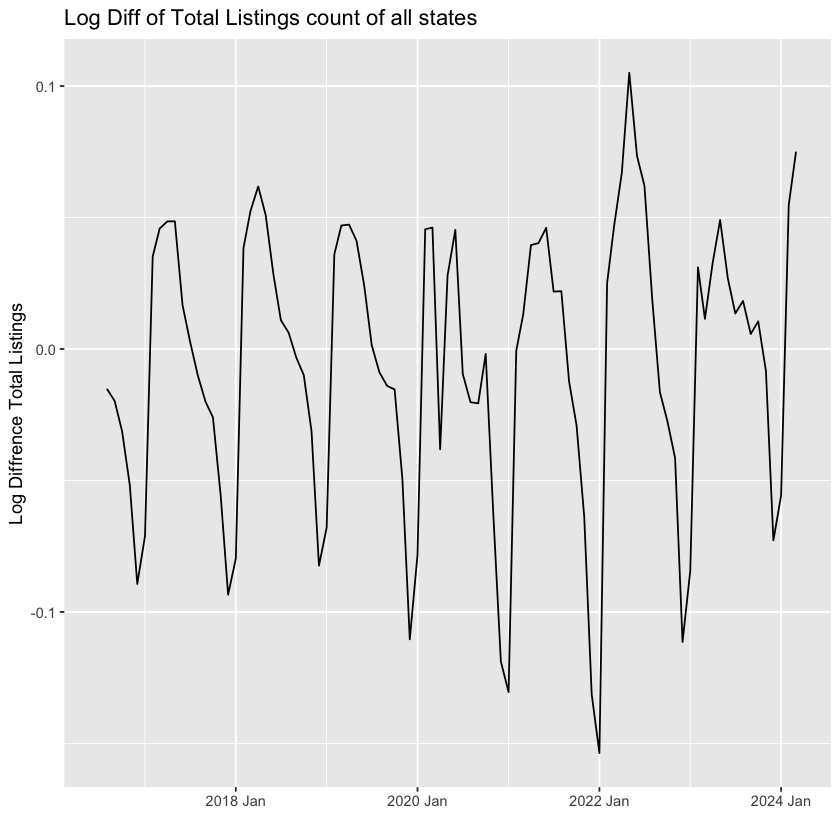

In [ ]:
# Plotting log differenced total listings over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(log(total_listings)))) +
  geom_line() +
  labs(title = 'Log Diff of Total Listings count of all states', x = '', y = 'Log Diffrence Total Listings')

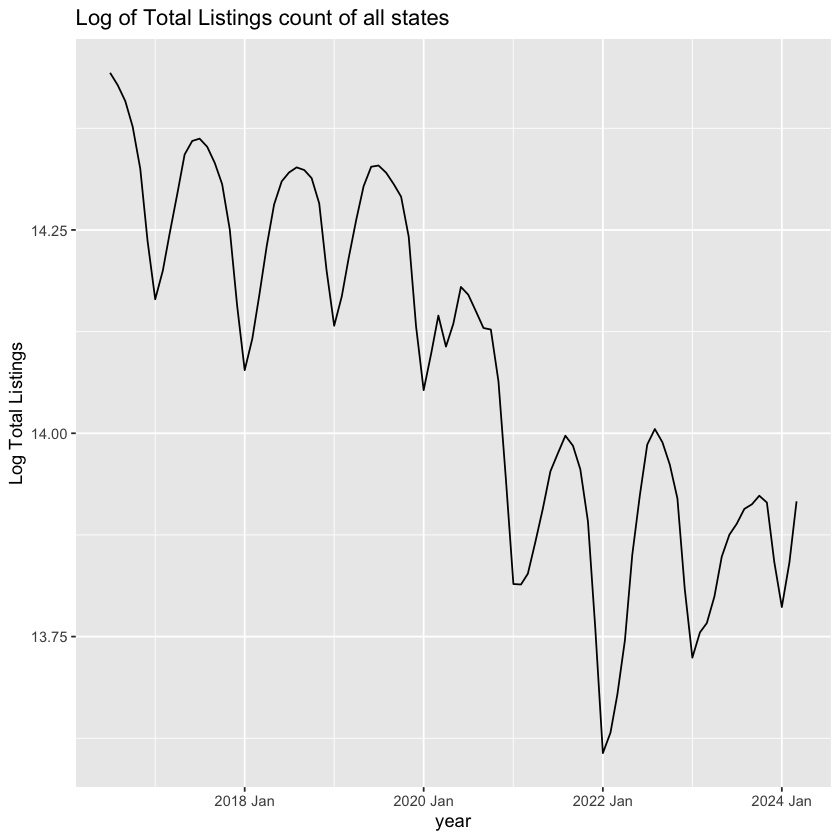

In [ ]:
# Plotting log of total listings over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = log(total_listings))) +
  geom_line() +
  labs(title = 'Log of Total Listings count of all states', x = 'year', y = 'Log Total Listings')

Differenced and the log differenced plots are looking similar with ups and downs throughout the timeline. But the log plot is similar to the actual plot. Let's check for seasonality.

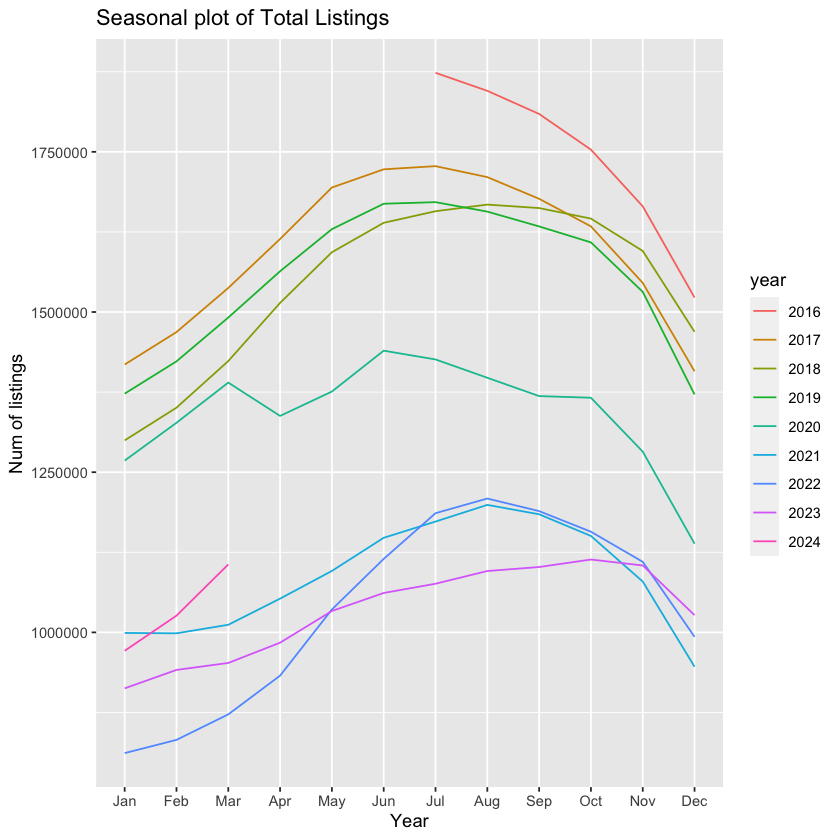

In [ ]:
#Seasonal plot of the total listings
ts(df_ts_aggregated$total_listings, frequency = 12, start = c(2016, 7)) %>% 
ggseasonplot() + 
ggtitle('Seasonal plot of Total Listings') + labs(y = "Num of listings", x = "Year")

There is a rise in the middle of every year i.e., May to August.

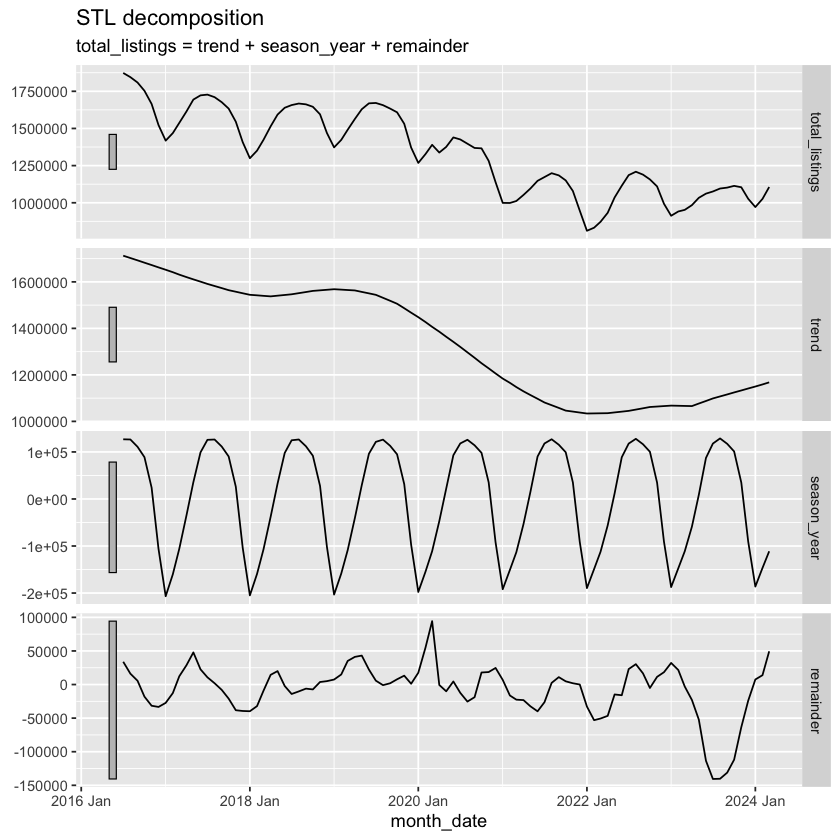

In [ ]:
# Let's decompose the total_listings
total_listings_decomp <- df_ts_aggregated |>
  model(
    stl = STL(total_listings , robust = TRUE)
  ) |>
  components()
total_listings_decomp |> autoplot()

As assumed there is a downward trend in the total listings data. Let us check for the outliers with Interquartile filtering. 

In [ ]:
outliers <- total_listings_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date total_listings trend   season_year remainder season_adjust
1 stl    2023 Jul   1075928        1098693 117795.5    -140560.1 958132.5     
2 stl    2023 Aug   1095774        1107293 128744.1    -140262.7 967029.9

In [ ]:
outliers %>% dim()

[1] 2 7

We can see 2 outliers in the total listings. 

In [ ]:
# Replacing outliers with NA
total_listings_miss <- df_ts_aggregated |>
  select(total_listings) %>%
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

total_listings_miss %>% filter_index('2023 May' ~ '2023 Nov')

Joining with `by = join_by(total_listings, month_date)`


total_listings month_date
1 1033383        2023 May  
2 1061509        2023 Jun  
3      NA        2023 Jul  
4      NA        2023 Aug  
5 1102034        2023 Sep  
6 1113692        2023 Oct  
7 1104433        2023 Nov

In [ ]:
#Filling the missed value using interpolation with ARIMA
total_listings_fill <- total_listings_miss |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(total_listings)) |>
  # Estimate missing total listings for all periods
  interpolate(total_listings_miss)

total_listings_fill %>% filter_index('2023 May' ~ '2023 Nov')

month_date total_listings
1 2023 May   1033383       
2 2023 Jun   1061509       
3 2023 Jul   1265929       
4 2023 Aug   1258923       
5 2023 Sep   1102034       
6 2023 Oct   1113692       
7 2023 Nov   1104433

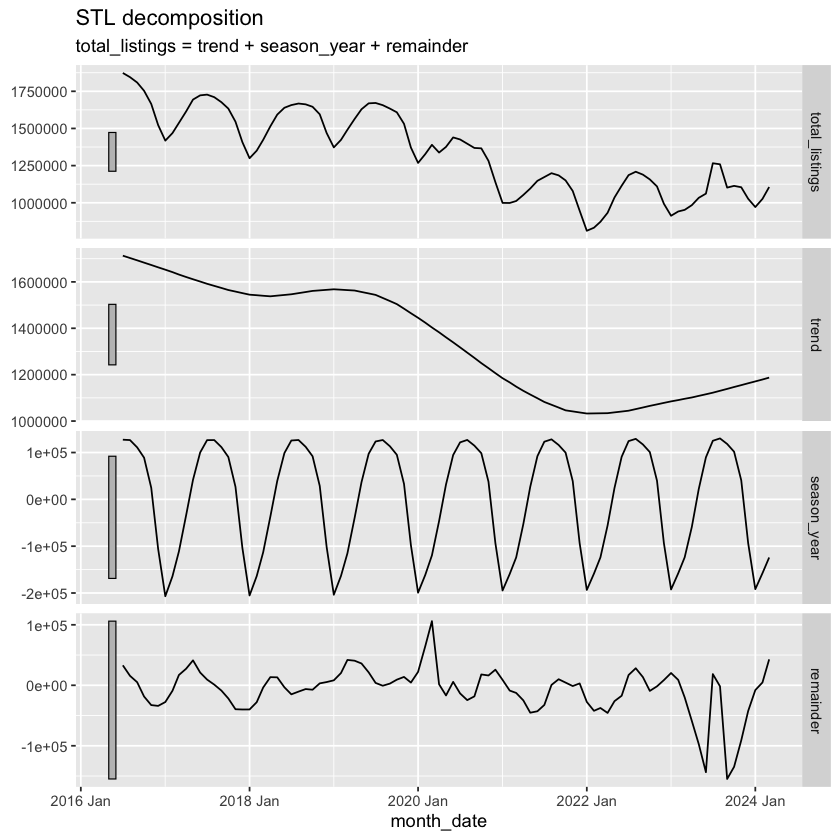

In [ ]:
# Decomposing the obtained total_listings to check if there are any outliers.
total_listings_decomp <- total_listings_fill |>
  model(
    stl = STL(total_listings , robust = TRUE)
  ) |>
  components()
total_listings_decomp |> autoplot()

In [ ]:
outliers <- total_listings_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date total_listings trend   season_year remainder season_adjust
1 stl    2023 Jun   1061509        1115445  89743.72   -143680.1 971765.3     
2 stl    2023 Sep   1102034        1138638 118281.44   -154885.5 983752.6

In [ ]:
# This time outliers are inthe other timeperiod.  
total_listings_fill <- total_listings_fill |>
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

total_listings_fill %>% filter_index('2023 May' ~ '2023 Nov')

Joining with `by = join_by(month_date, total_listings)`


month_date total_listings
1 2023 May   1033383       
2 2023 Jun        NA       
3 2023 Jul   1265929       
4 2023 Aug   1258923       
5 2023 Sep        NA       
6 2023 Oct   1113692       
7 2023 Nov   1104433

In [ ]:
total_listings_fill <- total_listings_fill |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(total_listings)) |>
  # Estimate the missing values for all periods
  interpolate(total_listings_fill)

total_listings_fill %>% filter_index('2023 May' ~ '2023 Nov')

month_date total_listings
1 2023 May   1033383       
2 2023 Jun   1152470       
3 2023 Jul   1265929       
4 2023 Aug   1258923       
5 2023 Sep   1173058       
6 2023 Oct   1113692       
7 2023 Nov   1104433

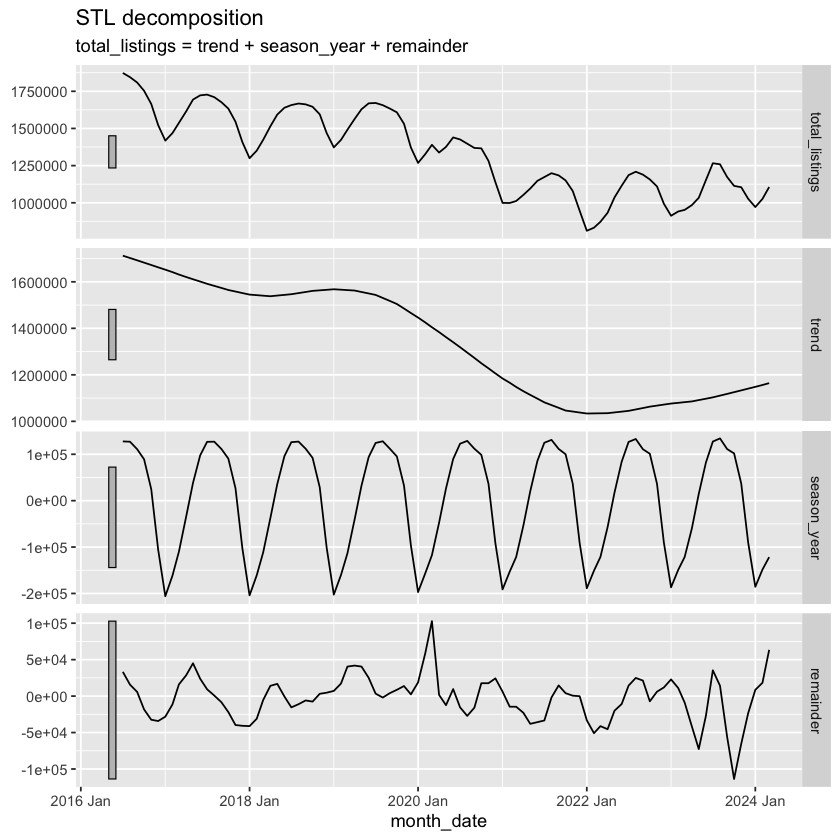

In [ ]:
total_listings_decomp <- total_listings_fill |>
  model(
    stl = STL(total_listings , robust = TRUE)
  ) |>
  components()
total_listings_decomp |> autoplot()

In [ ]:
outliers <- total_listings_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date total_listings trend season_year remainder season_adjust

Finally after decomposing the total_listings twice we can see there are no outliers.

### New Listings

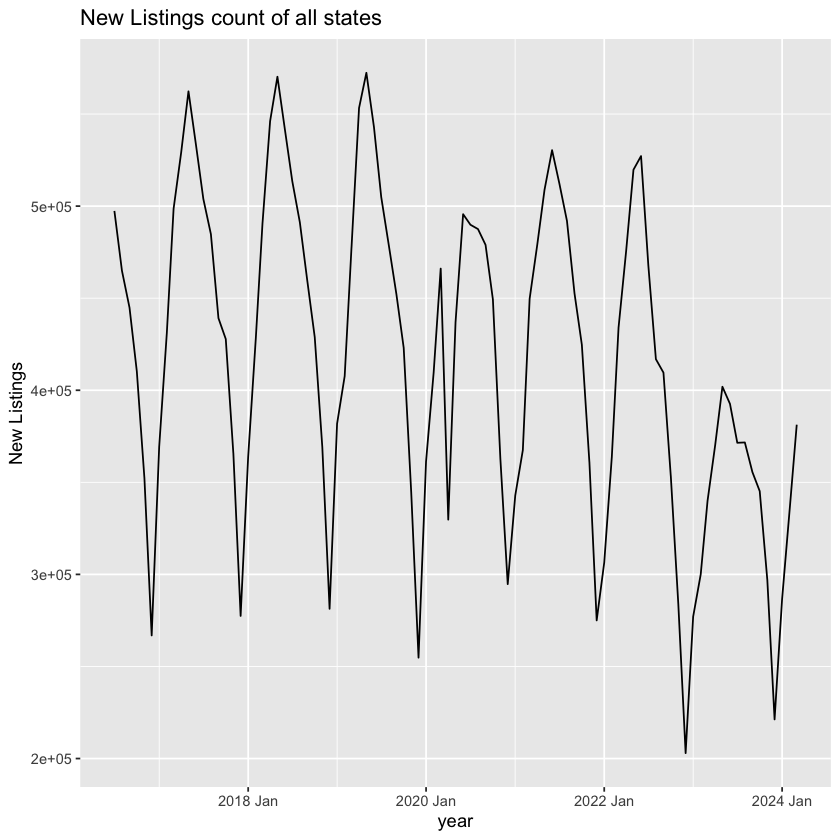

In [ ]:
# Plotting New listings over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = new_listings)) +
  geom_line() +
  labs(title = 'New Listings count of all states', x = 'year', y = 'New Listings')

In the initial time period, there is no change in year to year new listings, but after 2019, a slight downfall is observed for 3 years, which is aggain seen after 2023.

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


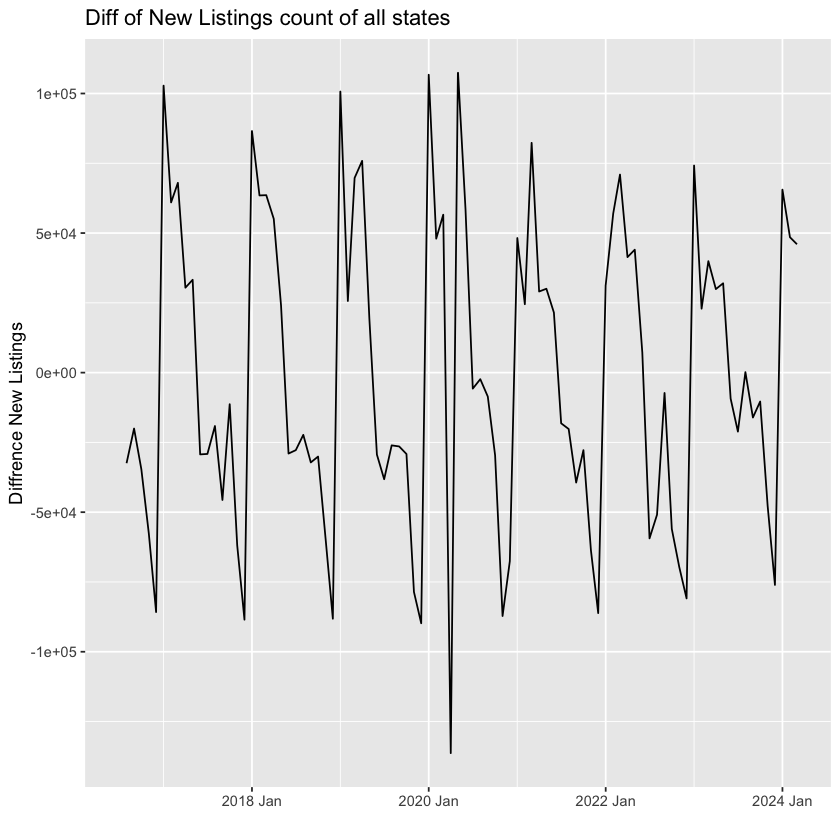

In [ ]:
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(new_listings))) +
  geom_line() +
  labs(title = 'Diff of New Listings count of all states', x = '', y = 'Diffrence New Listings')

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


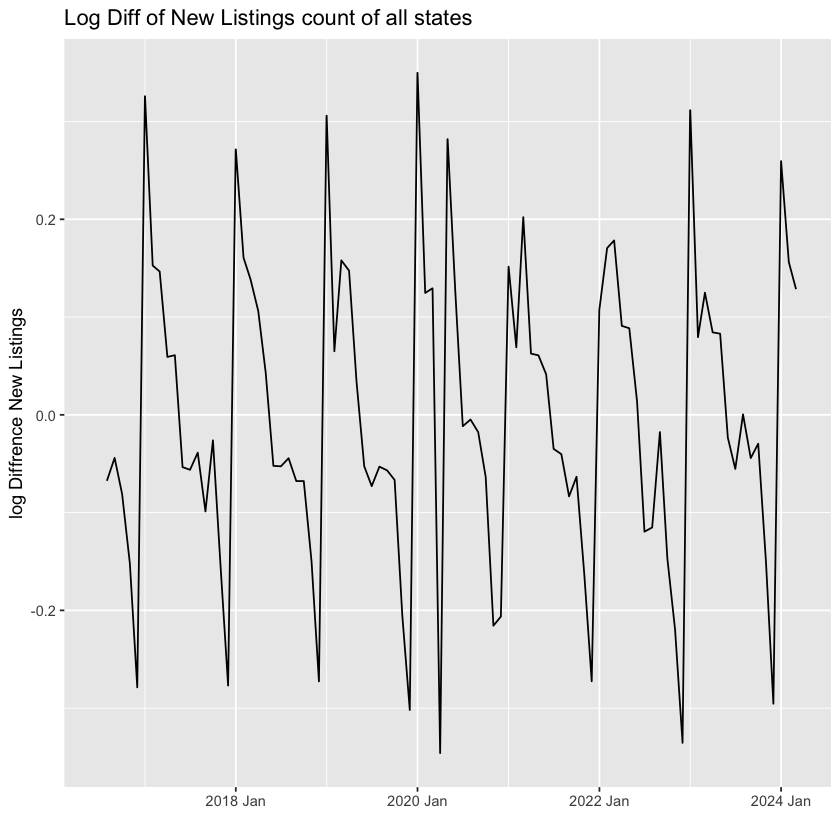

In [ ]:
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(log(new_listings)))) +
  geom_line() +
  labs(title = 'Log Diff of New Listings count of all states', x = '', y = 'log Diffrence New Listings')

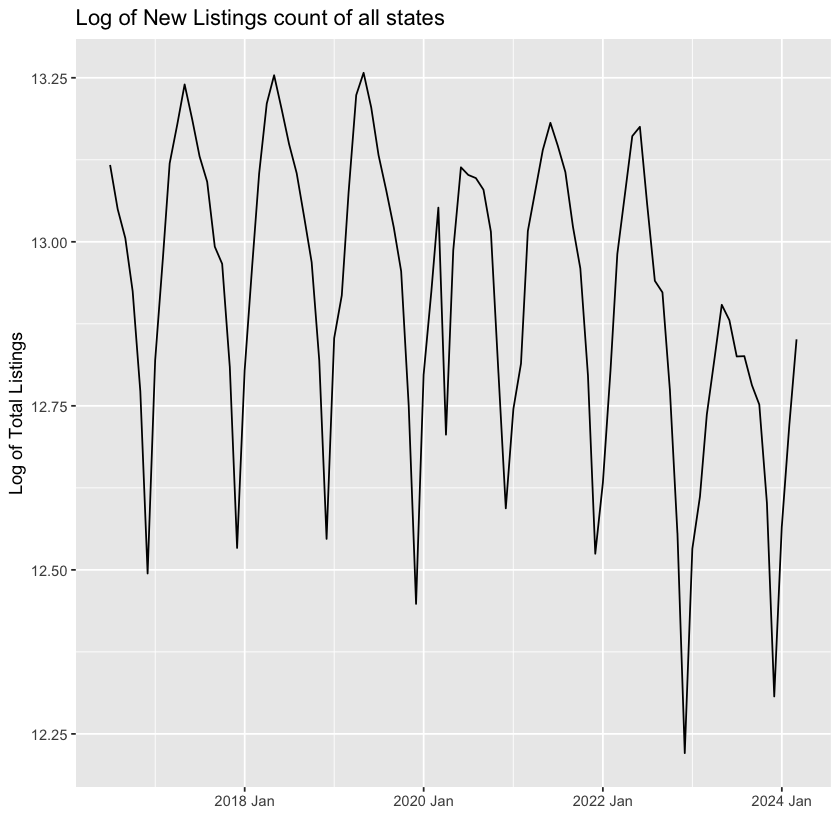

In [ ]:
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = log(new_listings))) +
  geom_line() +
  labs(title = 'Log of New Listings count of all states', x = '', y = 'Log of Total Listings')

Log plot remains the same, but the differenced and the log differenced plots look similar. Let's plot the seasonal plot.

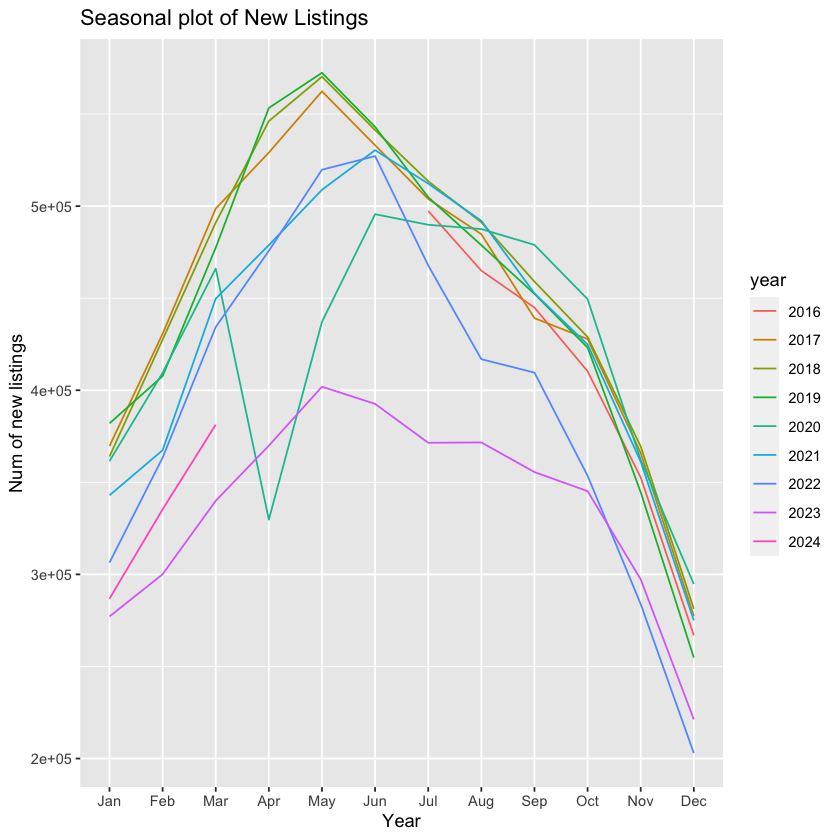

In [ ]:
ts(df_ts_aggregated$new_listings, frequency = 12, start = c(2016, 7)) %>% 
ggseasonplot() + 
ggtitle('Seasonal plot of New Listings') + labs(y = "Num of new listings", x = "Year")

From the seasonal plot we can see that new listings are high in the May of every year and low in the december month.

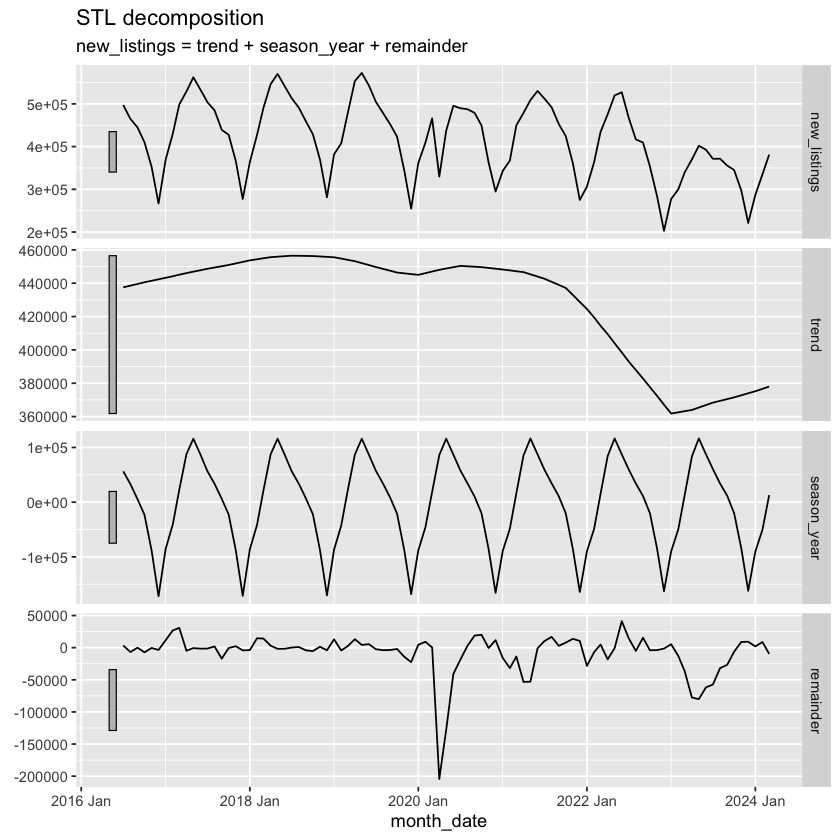

In [ ]:
new_listings_decomp <- df_ts_aggregated |>
  model(
    stl = STL(new_listings , robust = TRUE)
  ) |>
  components()
new_listings_decomp |> autoplot()

STL decomposition plot shows the down fall trend after 2021 and there is one spike in residuals around Feb 2020 (initial covid days). This could be because of the complete lockdown.

In [ ]:
outliers <- new_listings_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date new_listings trend    season_year remainder  season_adjust
1 stl    2020 Apr   329748       448020.8  86073.09   -204345.88 243674.9     
2 stl    2020 May   437164       448809.5 116177.04   -127822.58 320987.0     
3 stl    2021 Apr   478814       446658.4  85340.94    -53185.33 393473.1     
4 stl    2021 May   508862       445330.6 116443.13    -52911.68 392418.9     
5 stl    2023 Apr   369910       363969.0  83547.95    -77606.96 286362.1     
6 stl    2023 May   401916       365436.0 116542.60    -80062.59 285373.4     
7 stl    2023 Jun   392610       366903.0  87434.82    -61727.79 305175.2     
8 stl    2023 Jul   371478       368369.9  60516.68    -57408.63 310961.3

In [ ]:
# Interquartile shows multiple outliers, lets replace the outliers with null values and fill them.
new_listings_miss <- df_ts_aggregated |>
  select(new_listings) %>%
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

new_listings_miss %>% filter_index('2020 Apr' ~ '2023 Aug')

Joining with `by = join_by(new_listings, month_date)`


new_listings month_date
1      NA       2020 Apr  
2      NA       2020 May  
3  495614       2020 Jun  
4  489878       2020 Jul  
5  487532       2020 Aug  
6  478956       2020 Sep  
7  449470       2020 Oct  
8  362272       2020 Nov  
9  294722       2020 Dec  
10 342934       2021 Jan  
11 367444       2021 Feb  
12 449758       2021 Mar  
13     NA       2021 Apr  
14     NA       2021 May  
15 530384       2021 Jun  
16 512224       2021 Jul  
17 492028       2021 Aug  
18 452642       2021 Sep  
19 424866       2021 Oct  
20 361172       2021 Nov  
21 275022       2021 Dec  
22 306394       2022 Jan  
23 363382       2022 Feb  
24 434338       2022 Mar  
25 475716       2022 Apr  
26 519758       2022 May  
27 527174       2022 Jun  
28 467788       2022 Jul  
29 416882       2022 Aug  
30 409584       2022 Sep  
31 353576       2022 Oct  
32 283844       2022 Nov  
33 202948       2022 Dec  
34 277142       2023 Jan  
35 300056       2023 Feb  
36 339986       2023 Mar  
37     NA       2023 Apr  
38     NA       2023 May  
39     NA       2023 Jun  
40     NA       2023 Jul  
41 371656       2023 Aug

In [ ]:
# Using interpolation and ARIMA to fill the missing values
new_listings_fill <- new_listings_miss |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(new_listings)) |>
  # Estimate missing values for all periods
  interpolate(new_listings_miss)

new_listings_fill %>% filter_index('2020 Apr' ~ '2023 Aug')

month_date new_listings
1  2020 Apr   502427.4    
2  2020 May   515477.4    
3  2020 Jun   495614.0    
4  2020 Jul   489878.0    
5  2020 Aug   487532.0    
6  2020 Sep   478956.0    
7  2020 Oct   449470.0    
8  2020 Nov   362272.0    
9  2020 Dec   294722.0    
10 2021 Jan   342934.0    
11 2021 Feb   367444.0    
12 2021 Mar   449758.0    
13 2021 Apr   501318.9    
14 2021 May   532519.2    
15 2021 Jun   530384.0    
16 2021 Jul   512224.0    
17 2021 Aug   492028.0    
18 2021 Sep   452642.0    
19 2021 Oct   424866.0    
20 2021 Nov   361172.0    
21 2021 Dec   275022.0    
22 2022 Jan   306394.0    
23 2022 Feb   363382.0    
24 2022 Mar   434338.0    
25 2022 Apr   475716.0    
26 2022 May   519758.0    
27 2022 Jun   527174.0    
28 2022 Jul   467788.0    
29 2022 Aug   416882.0    
30 2022 Sep   409584.0    
31 2022 Oct   353576.0    
32 2022 Nov   283844.0    
33 2022 Dec   202948.0    
34 2023 Jan   277142.0    
35 2023 Feb   300056.0    
36 2023 Mar   339986.0    
37 2023 Apr   389538.0    
38 2023 May   421682.0    
39 2023 Jun   420068.7    
40 2023 Jul   396671.6    
41 2023 Aug   371656.0

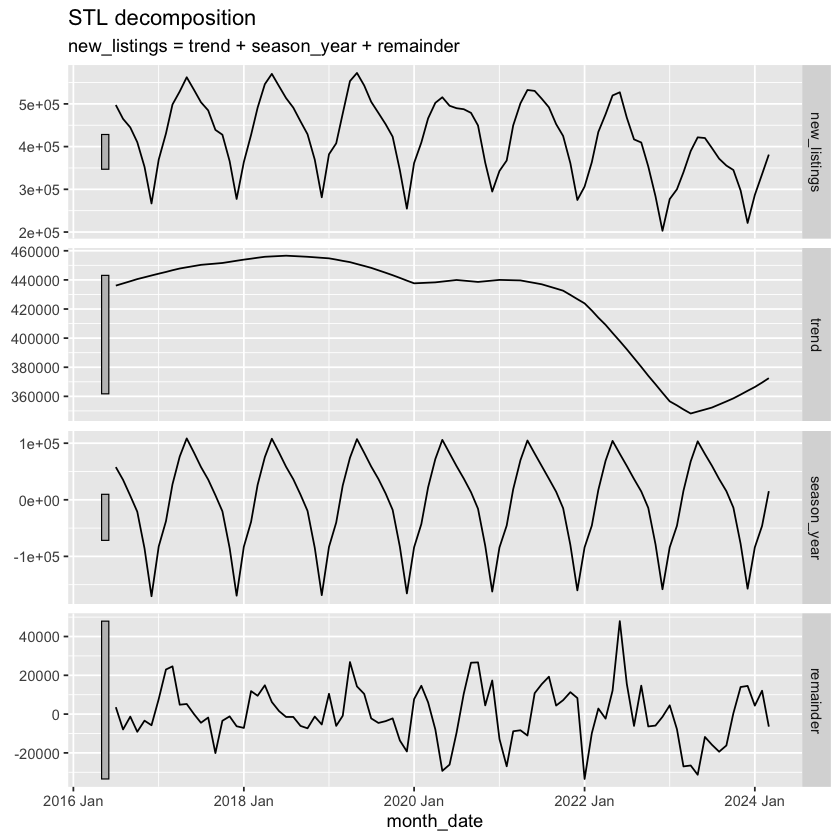

In [ ]:
#Checking for outliers again
new_listings_decomp <- new_listings_fill |>
  model(
    stl = STL(new_listings , robust = TRUE)
  ) |>
  components()
new_listings_decomp |> autoplot()

After replacing the outliers the residul plot is changed, lets check with  IQR again.

In [ ]:
outliers <- new_listings_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date new_listings trend season_year remainder season_adjust

From the above output we can see that all the outliers are successfully replaced.

### Weighted Median Square feet

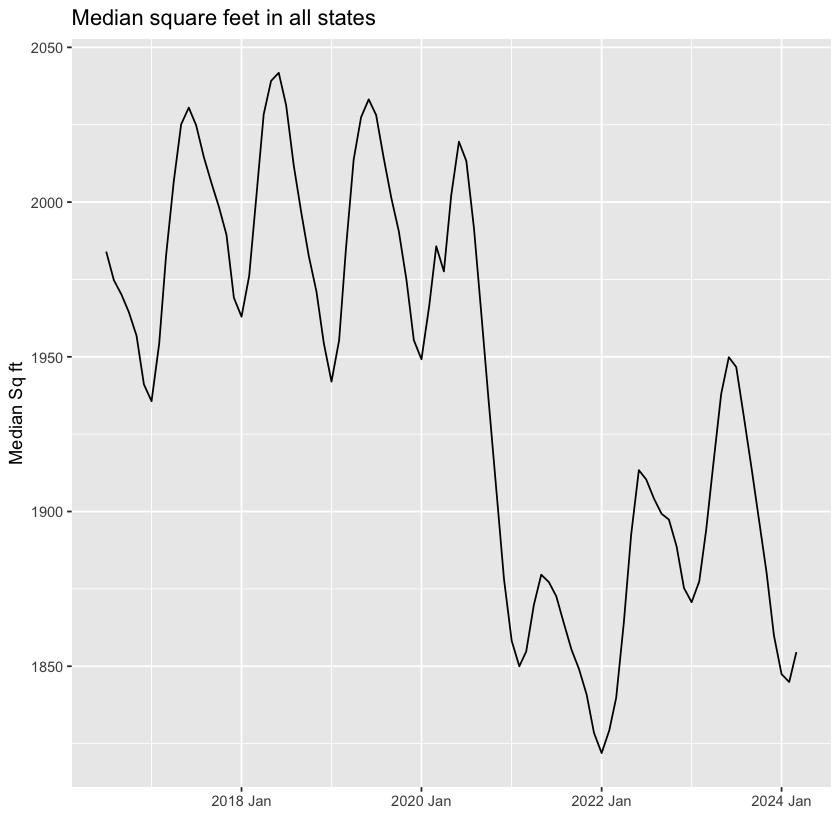

In [ ]:
# Plotting weighted median sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = wgt_median_square_feet)) +
  geom_line() +
  labs(title = 'Median square feet in all states', x = '', y = 'Median Sq ft')

The trend is similar till March 2020, but immidiately may be because of the covid, the median sqft went down than the 2016.

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


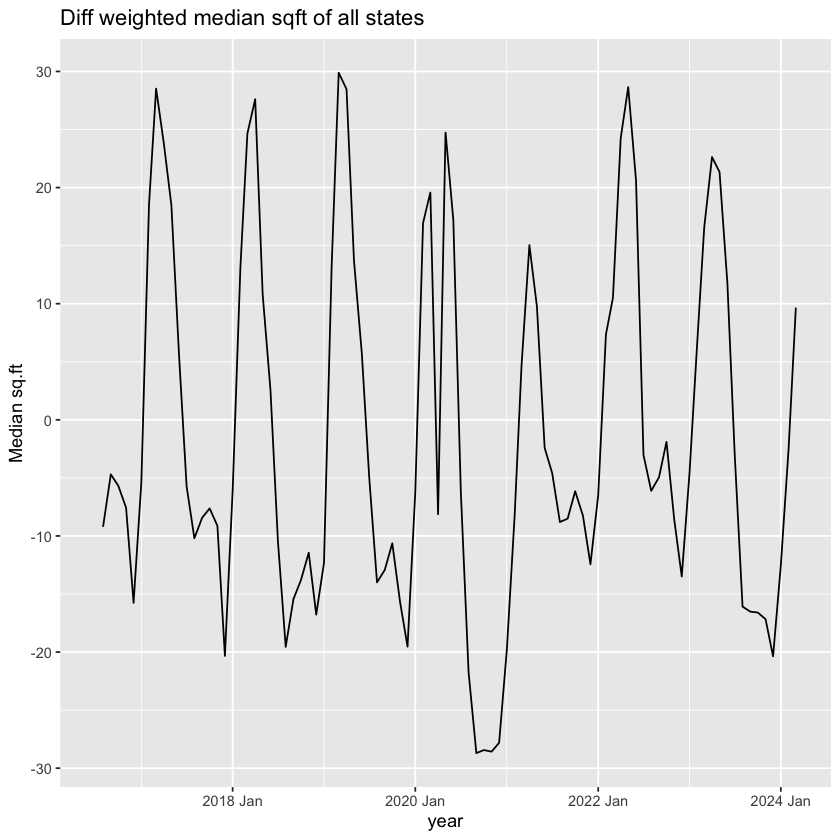

In [ ]:
# Plotting difference weighted median sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(wgt_median_square_feet))) +
  geom_line() +
  labs(title = 'Diff weighted median sqft of all states', x = 'year', y = 'Median sq.ft')

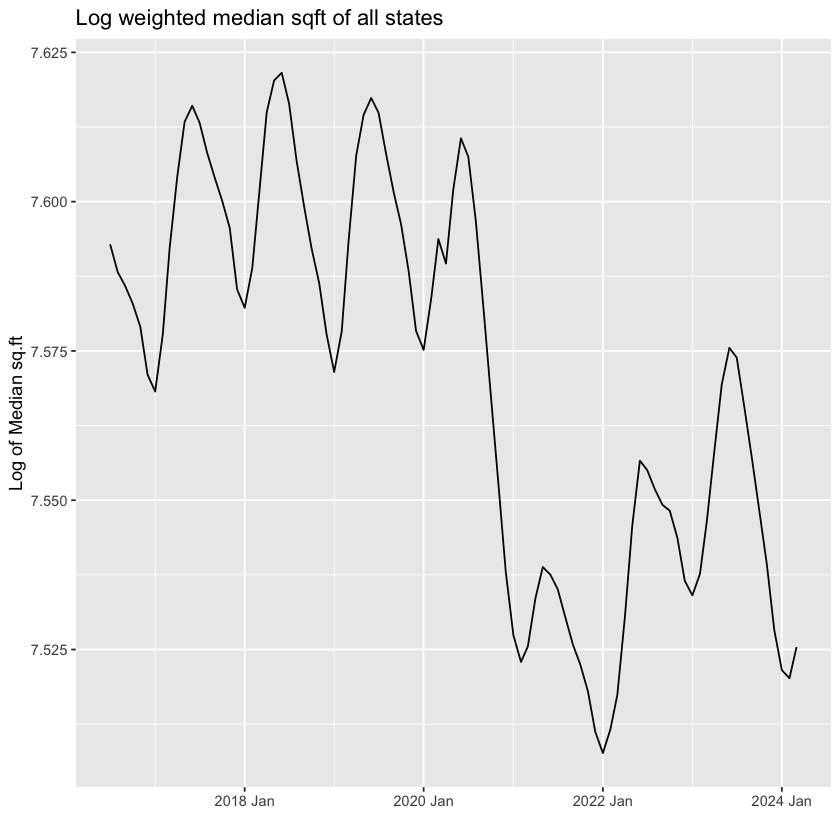

In [ ]:
# Plotting log weighted median sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = log(wgt_median_square_feet))) +
  geom_line() +
  labs(title = 'Log weighted median sqft of all states', x = '', y = 'Log of Median sq.ft')

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


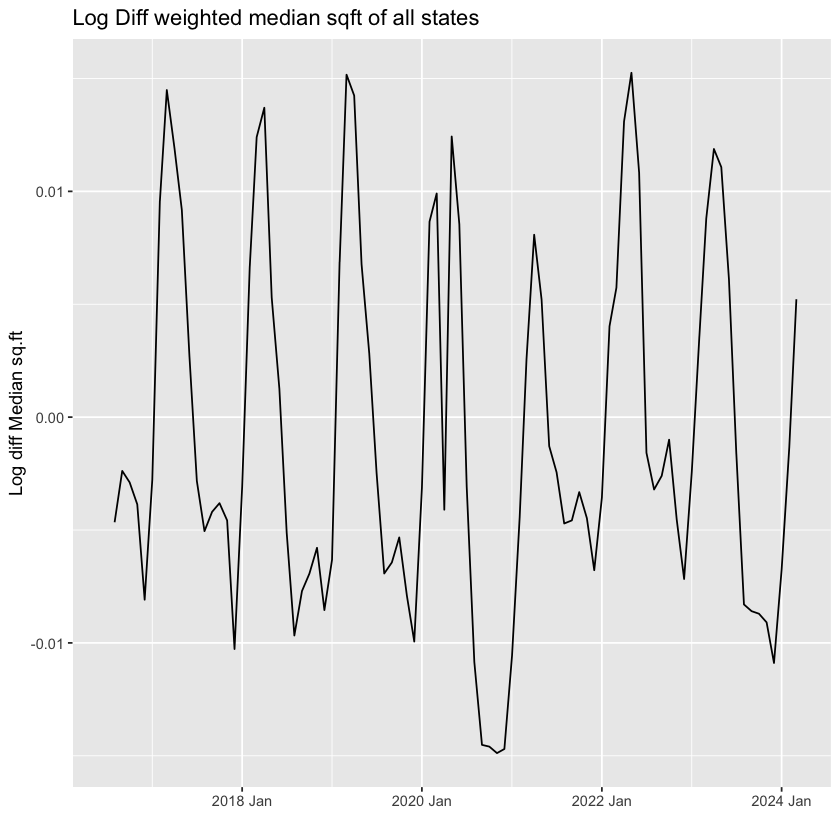

In [ ]:
# Plotting log differenced of weighted median sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(log(wgt_median_square_feet)))) +
  geom_line() +
  labs(title = 'Log Diff weighted median sqft of all states', x = '', y = 'Log diff Median sq.ft')

Similar to other metrics diffrenced and log differenced looks similar with patterns, so the change in the median square feet from year to year is same.

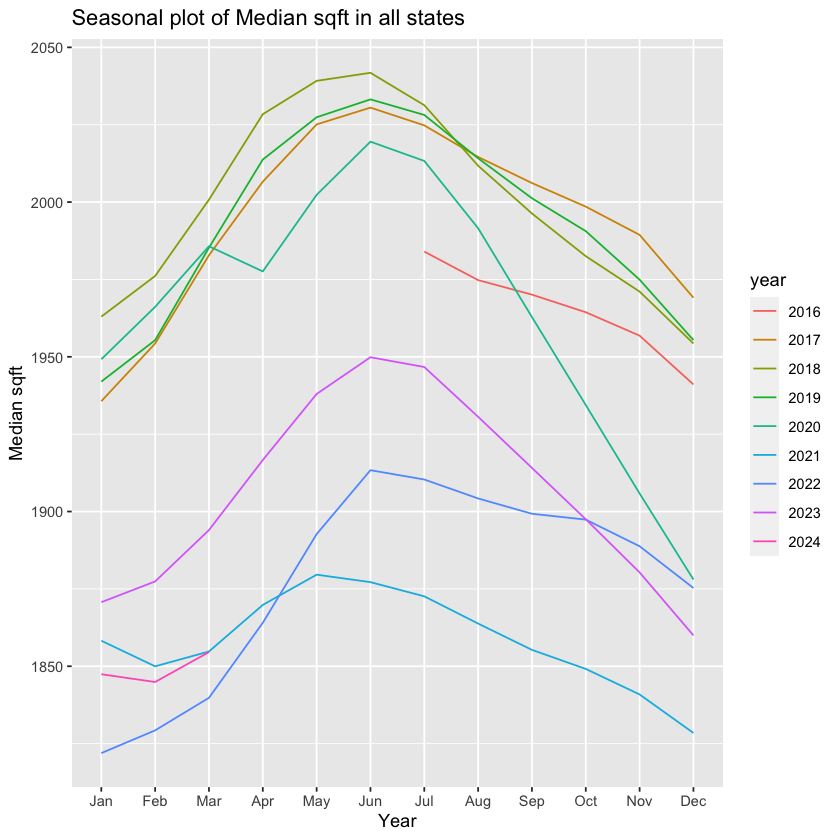

In [ ]:
#Seasonal plot of Median square feet.
ts(df_ts_aggregated$wgt_median_square_feet, frequency = 12, start = c(2016, 7)) %>% 
ggseasonplot() + 
ggtitle('Seasonal plot of Median sqft in all states') + labs(y = "Median sqft", x = "Year")

The median square feet is higher in the around the half of every year and least in the end and start of every year.

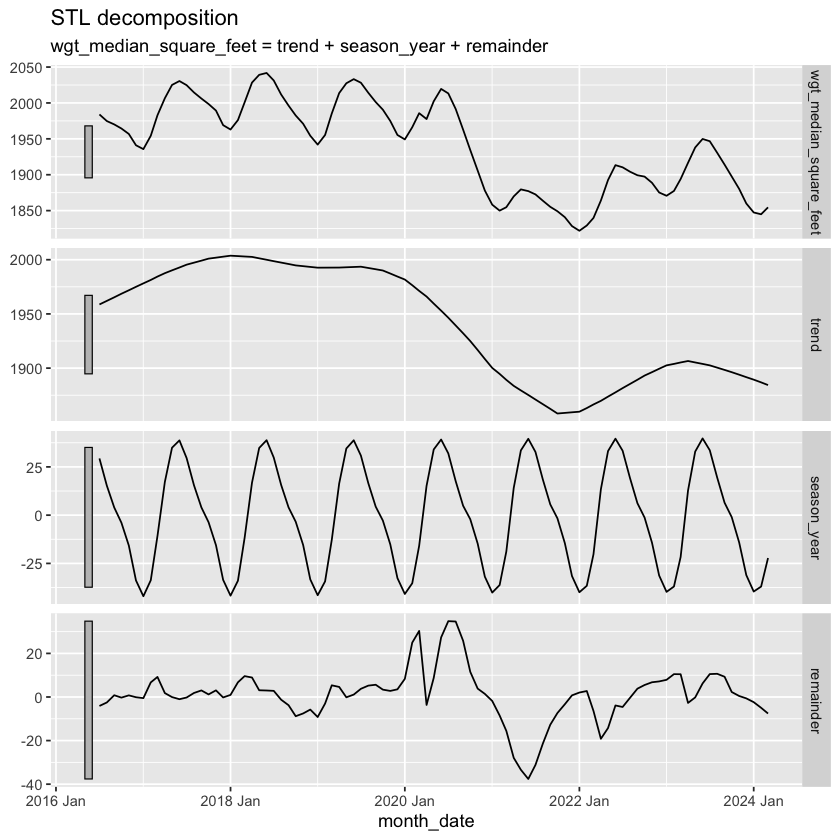

In [ ]:
# Checking for outliers using stl decomposition
wgt_median_square_feet_decomp <- df_ts_aggregated |>
  model(
    stl = STL(wgt_median_square_feet , robust = TRUE)
  ) |>
  components()
wgt_median_square_feet_decomp |> autoplot()

As assumed trend is declined after 2020 January and picked up after 2022 January.

In [ ]:
# Cheking outliers with IQR
outliers <- wgt_median_square_feet_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_square_feet trend    season_year remainder
1 stl    2020 Jul   2013.294               1946.502 31.98990     34.80265
2 stl    2020 Aug   1991.544               1939.323 17.58545     34.63504
3 stl    2021 May   1879.595               1879.437 33.56117    -33.40369
4 stl    2021 Jun   1877.182               1875.233 39.55948    -37.61100
5 stl    2021 Jul   1872.599               1871.030 32.74469    -31.17513
  season_adjust
1 1981.304     
2 1973.958     
3 1846.033     
4 1837.622     
5 1839.855

The above mentioned data is outliers data. So replace them with null values and fill them with interpolation. 

In [ ]:
# Replacing null values with null values
wgt_median_square_feet_miss <- df_ts_aggregated |>
  select(wgt_median_square_feet) %>%
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

wgt_median_square_feet_miss %>% filter_index('2020 May' ~ '2021 Aug')

Joining with `by = join_by(wgt_median_square_feet, month_date)`


wgt_median_square_feet month_date
1  2002.332               2020 May  
2  2019.525               2020 Jun  
3        NA               2020 Jul  
4        NA               2020 Aug  
5  1962.842               2020 Sep  
6  1934.404               2020 Oct  
7  1905.830               2020 Nov  
8  1878.021               2020 Dec  
9  1858.253               2021 Jan  
10 1849.974               2021 Feb  
11 1854.772               2021 Mar  
12 1869.816               2021 Apr  
13       NA               2021 May  
14       NA               2021 Jun  
15       NA               2021 Jul  
16 1863.797               2021 Aug

In [ ]:
#Filling the data with interpolation and ARIMA model
wgt_median_square_feet_fill <- wgt_median_square_feet_miss |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(wgt_median_square_feet)) |>
  # Estimate missing values for all periods
  interpolate(wgt_median_square_feet_miss)

wgt_median_square_feet_fill %>% filter_index('2020 May' ~ '2021 Aug')

month_date wgt_median_square_feet
1  2020 May   2002.332              
2  2020 Jun   2019.525              
3  2020 Jul   2006.651              
4  2020 Aug   1984.397              
5  2020 Sep   1962.842              
6  2020 Oct   1934.404              
7  2020 Nov   1905.830              
8  2020 Dec   1878.021              
9  2021 Jan   1858.253              
10 2021 Feb   1849.974              
11 2021 Mar   1854.772              
12 2021 Apr   1869.816              
13 2021 May   1880.081              
14 2021 Jun   1883.397              
15 2021 Jul   1880.206              
16 2021 Aug   1863.797

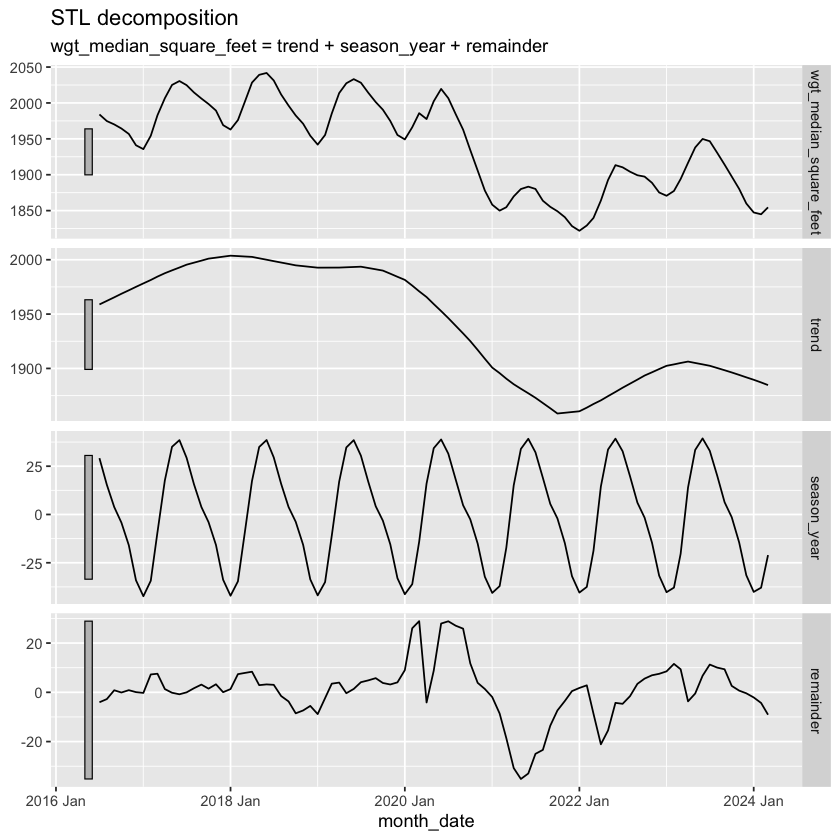

In [ ]:
# Checking again for the outliers
wgt_median_square_feet_decomp <- wgt_median_square_feet_fill |>
  model(
    stl = STL(wgt_median_square_feet , robust = TRUE)
  ) |>
  components()
wgt_median_square_feet_decomp |> autoplot()

In [ ]:
# Using IQR
outliers <- wgt_median_square_feet_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_square_feet trend    season_year remainder
1 stl    2021 May   1880.081               1881.318 33.94193    -35.17811
2 stl    2021 Jun   1883.397               1877.161 39.19629    -32.96005
  season_adjust
1 1846.139     
2 1844.200

After replacing the outliers for the first time, again we found found the outliers in 2021 May and 2021 June. So replacing the outliers again.

In [ ]:
# Filling with null values
wgt_median_square_feet_fill <- wgt_median_square_feet_fill |>
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

wgt_median_square_feet_fill %>% filter_index('2021 Apr' ~ '2021 Aug')

Joining with `by = join_by(month_date, wgt_median_square_feet)`


month_date wgt_median_square_feet
1 2021 Apr   1869.816              
2 2021 May         NA              
3 2021 Jun         NA              
4 2021 Jul   1880.206              
5 2021 Aug   1863.797

In [ ]:
# Using interpolation with ARIMA
wgt_median_square_feet_fill <- wgt_median_square_feet_fill |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(wgt_median_square_feet)) |>
  # Estimate missing values for all periods
  interpolate(wgt_median_square_feet_fill)

wgt_median_square_feet_fill %>% filter_index('2021 Apr' ~ '2021 Aug')

month_date wgt_median_square_feet
1 2021 Apr   1869.816              
2 2021 May   1881.000              
3 2021 Jun   1884.127              
4 2021 Jul   1880.206              
5 2021 Aug   1863.797

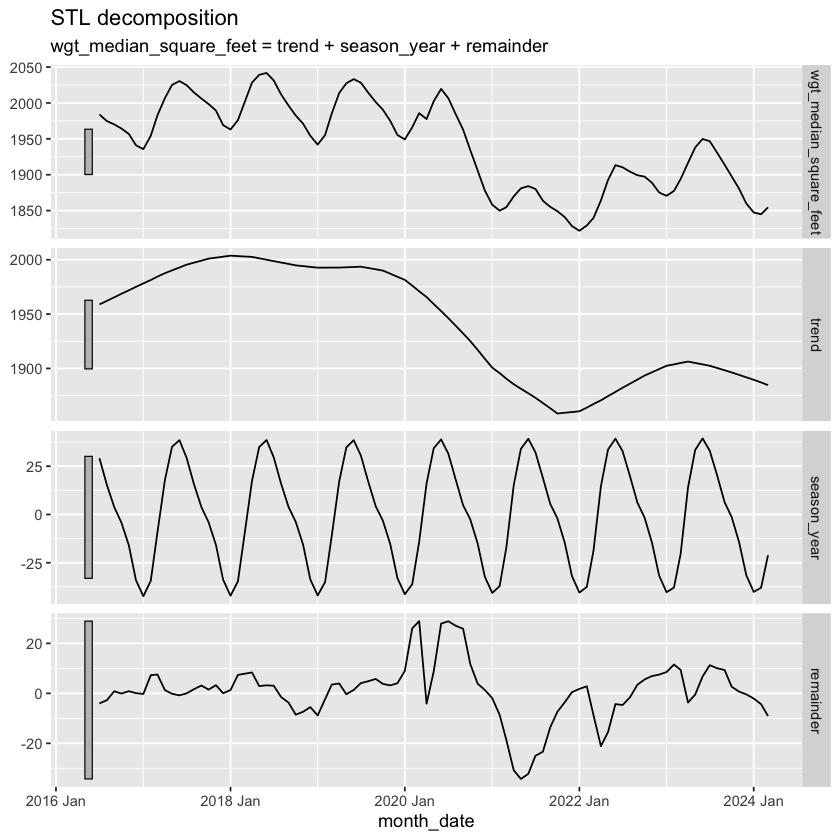

In [ ]:
wgt_median_square_feet_decomp <- wgt_median_square_feet_fill |>
  model(
    stl = STL(wgt_median_square_feet , robust = TRUE)
  ) |>
  components()
wgt_median_square_feet_decomp |> autoplot()

In [ ]:
outliers <- wgt_median_square_feet_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_square_feet trend    season_year remainder
1 stl    2021 May   1881.000               1881.317 33.94883    -34.26592
2 stl    2021 Jun   1884.127               1877.160 39.19450    -32.22745
  season_adjust
1 1847.051     
2 1844.932

Even after replacing the outliers second time, again we found the outliers in May and June of 2021 May and June, with small difference. 

### Weighted Median Price

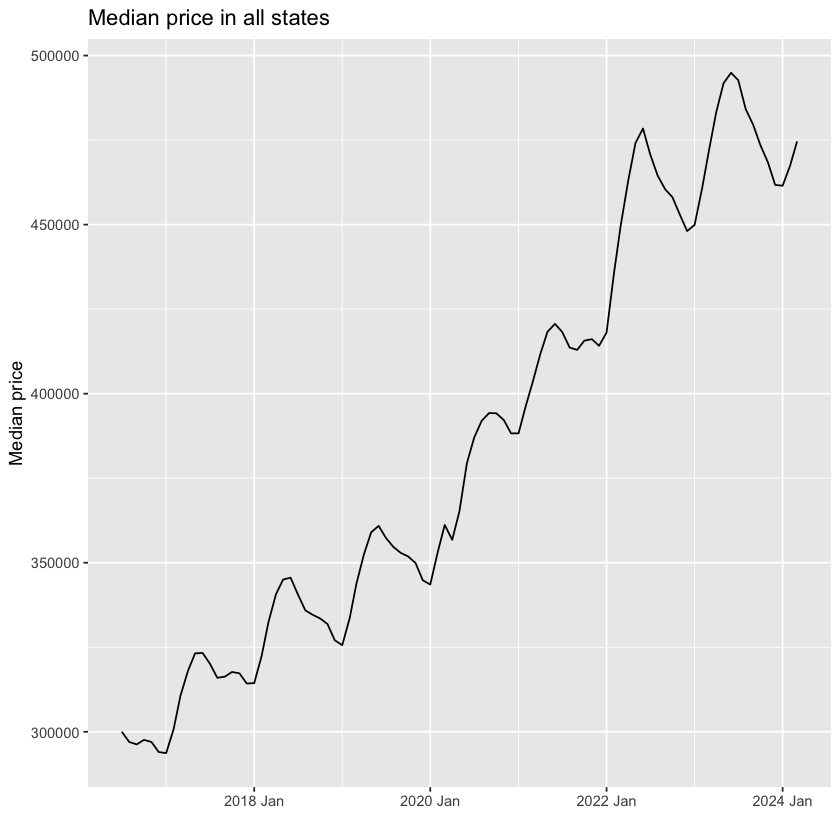

In [ ]:
# Plotting weighted median price over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = wgt_median_price)) +
  geom_line() +
  labs(title = 'Median price in all states', x = '', y = 'Median price')

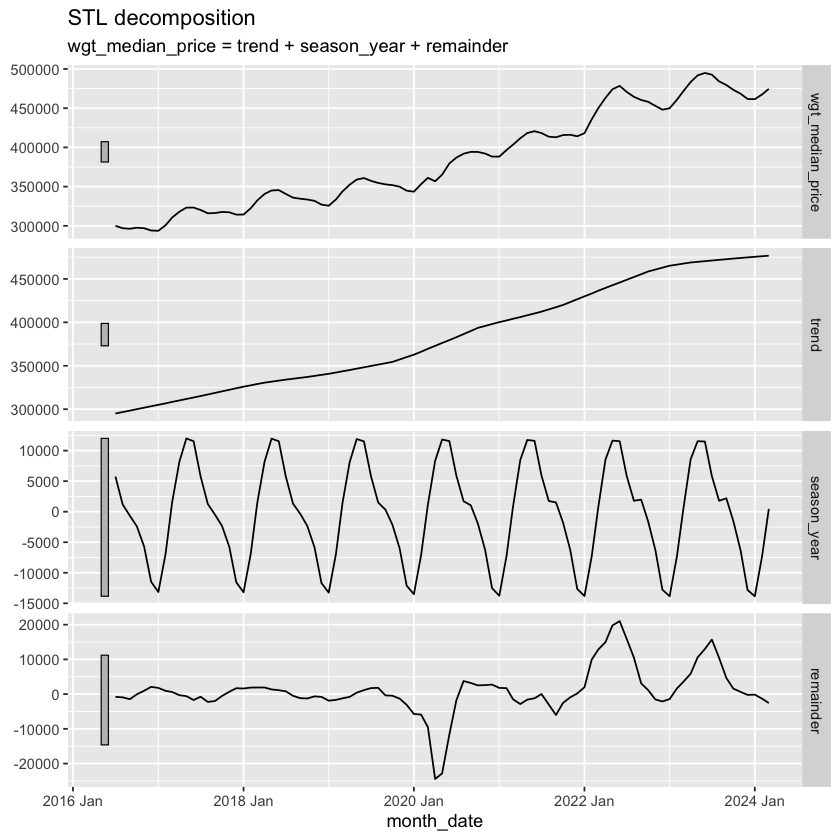

In [ ]:
# Decomposing the weighted median price using stl decomposition
wgt_median_price_feet_decomp <- df_ts_aggregated |>
  model(
    stl = STL(wgt_median_price , robust = TRUE)
  ) |>
  components()
wgt_median_price_feet_decomp |> autoplot()

In [ ]:
# Checking for outliers
outliers <- wgt_median_price_feet_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_price trend    season_year remainder
1  stl    2020 Apr   356770.1         372908.3  8303.5290  -24441.73
2  stl    2020 May   365221.4         376236.0 11823.2926  -22837.88
3  stl    2020 Jun   379476.1         379563.8 11561.4725  -11649.12
4  stl    2022 Mar   449886.4         436375.4   680.0647   12830.90
5  stl    2022 Apr   463100.9         439603.7  8516.6550   14980.60
6  stl    2022 May   474157.8         442733.1 11637.9878   19786.66
7  stl    2022 Jun   478415.8         445862.6 11536.4846   21016.74
8  stl    2022 Jul   470751.8         448992.0  5850.9099   15908.84
9  stl    2023 Jun   494903.4         470425.2 11487.4321   12990.85
10 stl    2023 Jul   492713.2         471186.6  5824.0528   15702.50
   season_adjust
1  348466.5     
2  353398.1     
3  367914.6     
4  449206.3     
5  454584.3     
6  462519.8     
7  466879.3     
8  464900.9     
9  483416.0     
10 486889.1

A total of 10 outliers are found in the weighted median square.

### Weighted Median Price per Square Foot

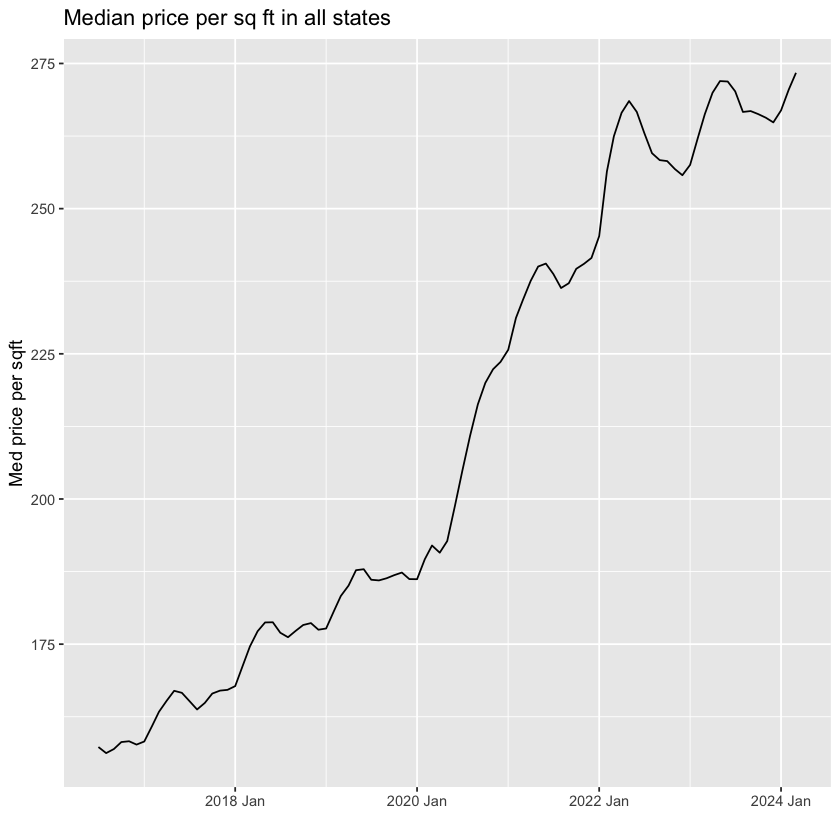

In [ ]:
# Plotting Weighted Median price per sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = wgt_median_price_per_sqft)) +
   geom_line() +
   labs(title = 'Median price per sq ft in all states', x = '', y = 'Med price per sqft')

Median price per sqft is increasing over the years. There are some seasonal patterns and the trend is upward.

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


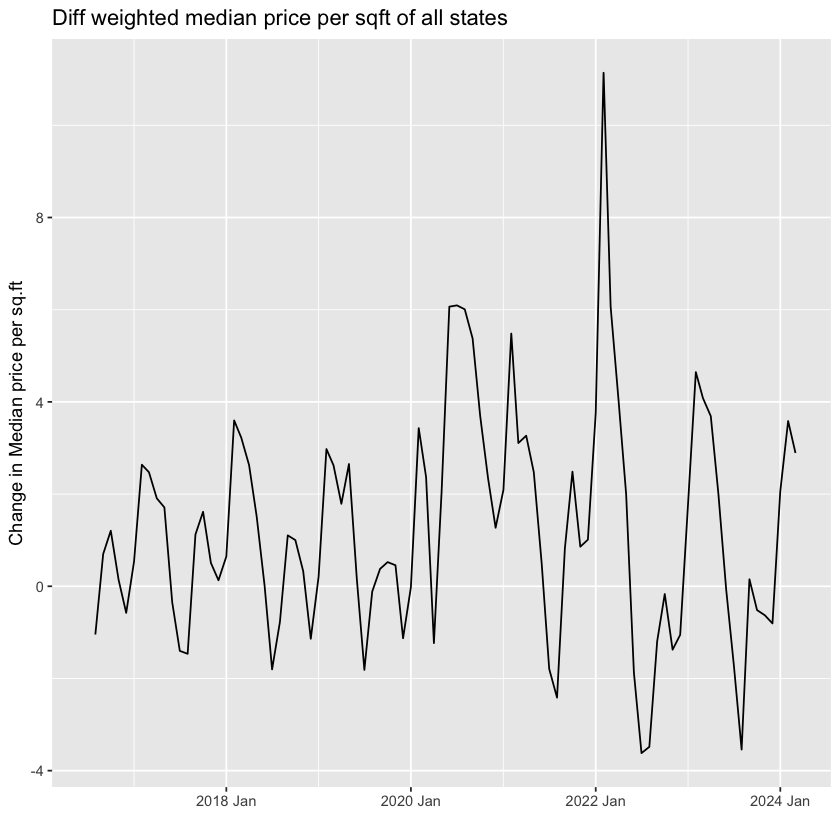

In [ ]:
# Plotting differenced Weighted Median price per sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(wgt_median_price_per_sqft))) +
  geom_line() +
  labs(title = 'Diff weighted median price per sqft of all states', x = '', y = 'Change in Median price per sq.ft')

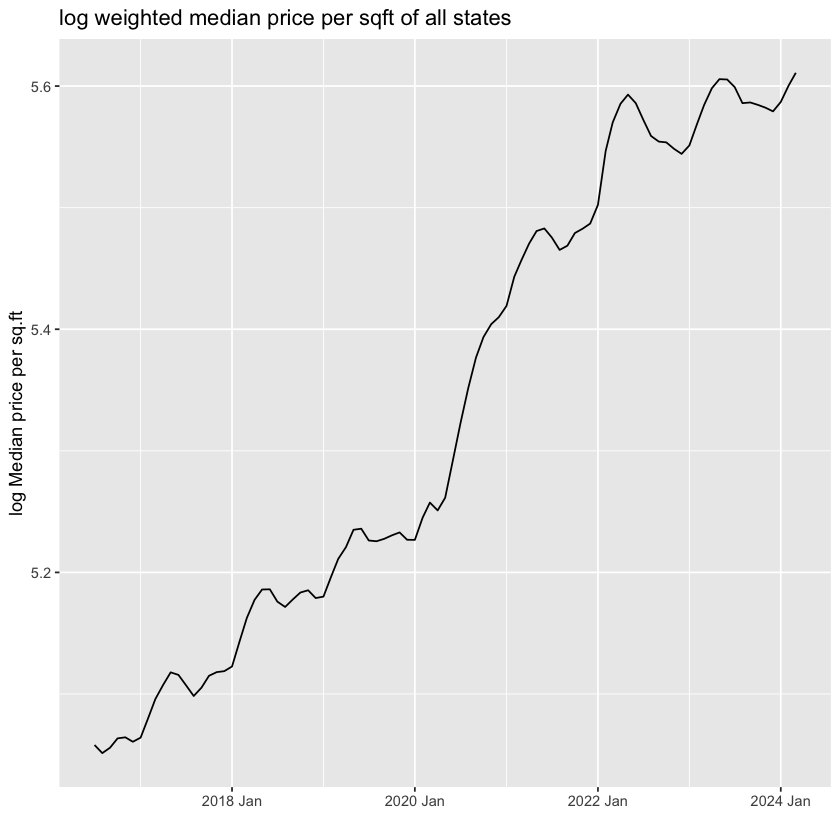

In [ ]:
# Plotting log Weighted Median price per sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = log(wgt_median_price_per_sqft))) +
  geom_line() +
  labs(title = 'log weighted median price per sqft of all states', x = '', y = 'log Median price per sq.ft')

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


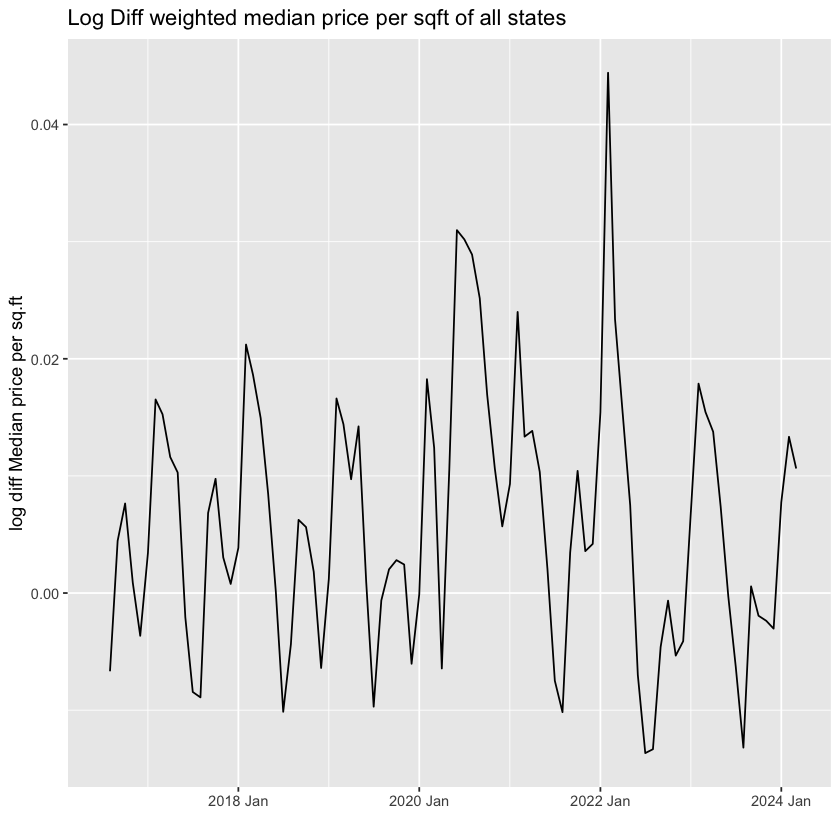

In [ ]:
# Plotting differenced Weighted Median price per sqft over time
ggplot(data = as.data.frame(df_ts_aggregated), aes(x = month_date, y = difference(log(wgt_median_price_per_sqft)))) +
  geom_line() +
  labs(title = 'Log Diff weighted median price per sqft of all states', x = '', y = 'log diff Median price per sq.ft')

Actual wt median price per sqft plot and the log of wt median price per sqft plot looks similar with upward trend, while the differenced plot appears multiplicative trend. But the log differenced looks like white noise.

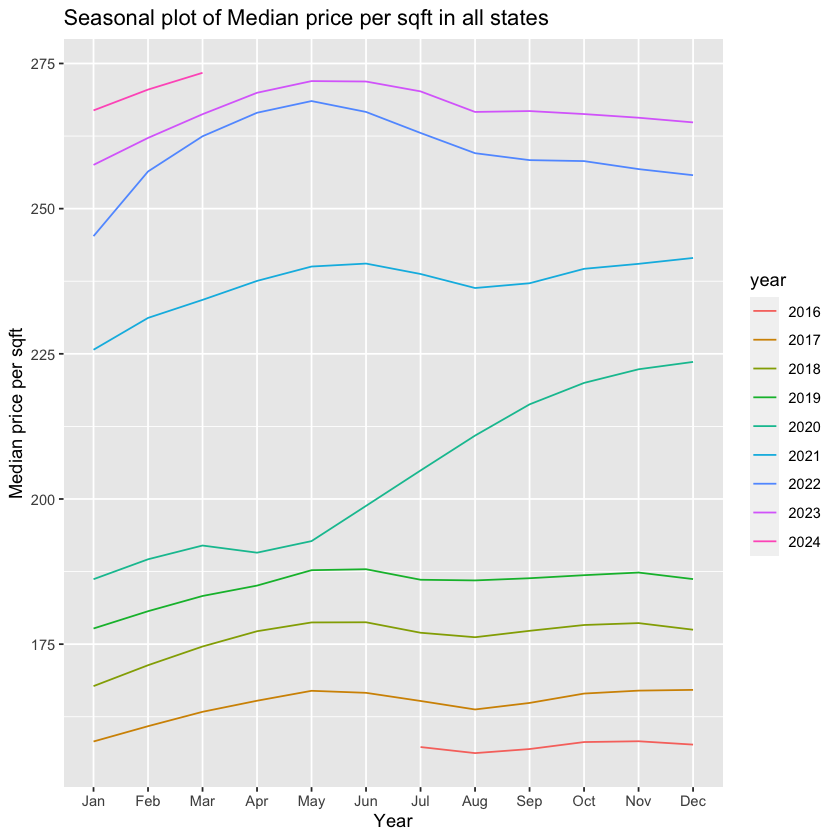

In [ ]:
# Seasonal plot of weighted median price per sqft
ts(df_ts_aggregated$wgt_median_price_per_sqft, frequency = 12, start = c(2016, 7)) %>% 
ggseasonplot() + 
ggtitle('Seasonal plot of Median price per sqft in all states') + labs(y = "Median price per sqft", x = "Year")

Median price per sqft is little higher around April, May, June except for 2020 year.

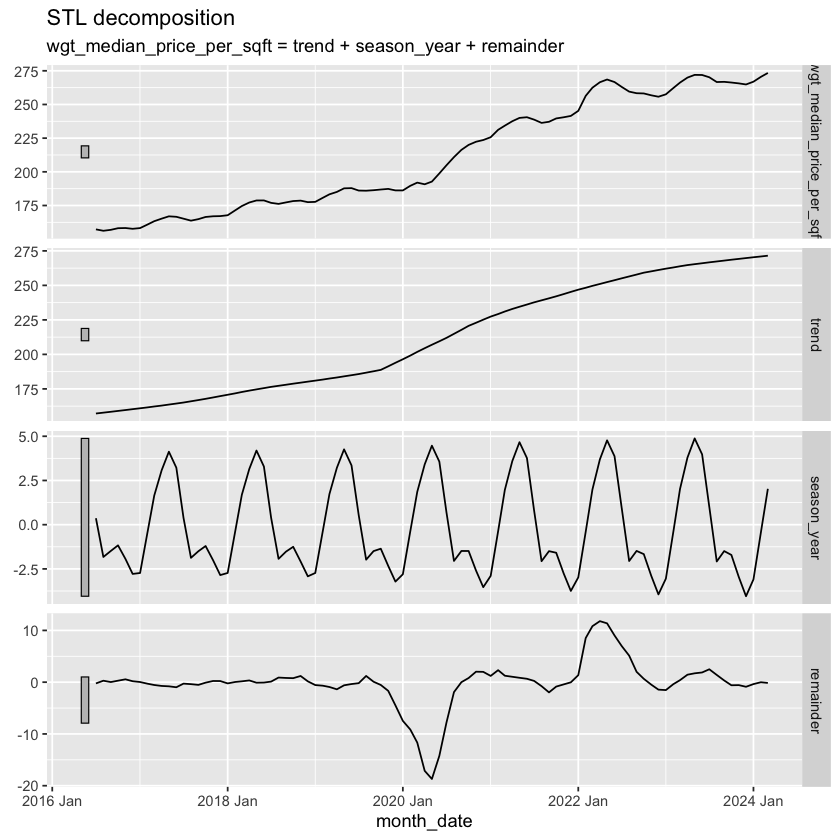

In [ ]:
# Cheking for outliers using stl decomposition
wgt_median_price_per_sqft_decomp <- df_ts_aggregated |>
  model(
    stl = STL(wgt_median_price_per_sqft , robust = TRUE)
  ) |>
  components()
wgt_median_price_per_sqft_decomp |> autoplot()

In [ ]:
# Outliers report
outliers <- wgt_median_price_per_sqft_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_price_per_sqft trend    season_year remainder 
1  stl    2020 Jan   186.1866                  196.4661 -2.8034050   -7.476148
2  stl    2020 Feb   189.6167                  199.1358 -0.3721315   -9.146926
3  stl    2020 Mar   191.9872                  201.8054  1.8567283  -11.675008
4  stl    2020 Apr   190.7547                  204.4751  3.4094145  -17.129802
5  stl    2020 May   192.7496                  206.9807  4.4680616  -18.699186
6  stl    2020 Jun   198.8154                  209.4864  3.5656830  -14.236695
7  stl    2020 Jul   204.9094                  211.9920  0.6682708   -7.750845
8  stl    2022 Feb   256.4017                  248.2689 -0.3968610    8.529633
9  stl    2022 Mar   262.4624                  249.6506  1.9909346   10.820910
10 stl    2022 Apr   266.5128                  251.0323  3.6902723   11.790219
11 stl    2022 May   268.5300                  252.3934  4.7698425   11.366760
12 stl    2022 Jun   266.6539                  253.7544  3.8717985    9.027671
13 stl    2022 Jul   263.0344                  255.1155  0.9375978    6.981298
   season_adjust
1  188.9900     
2  189.9889     
3  190.1304     
4  187.3453     
5  188.2816     
6  195.2497     
7  204.2412     
8  256.7985     
9  260.4715     
10 262.8225     
11 263.7601     
12 262.7821     
13 262.0968

All the outliers are in 2020 and 2022, let's replaace them with null and fill with interpolation.

In [ ]:
# filling with NA
wgt_median_price_per_sqft_miss <- df_ts_aggregated |>
  select(wgt_median_price_per_sqft) %>%
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

wgt_median_price_per_sqft_miss %>% filter_index('2020 Jan' ~ '2022 Jul')

Joining with `by = join_by(wgt_median_price_per_sqft, month_date)`


wgt_median_price_per_sqft month_date
1        NA                  2020 Jan  
2        NA                  2020 Feb  
3        NA                  2020 Mar  
4        NA                  2020 Apr  
5        NA                  2020 May  
6        NA                  2020 Jun  
7        NA                  2020 Jul  
8  210.9174                  2020 Aug  
9  216.2949                  2020 Sep  
10 219.9900                  2020 Oct  
11 222.3388                  2020 Nov  
12 223.6078                  2020 Dec  
13 225.7007                  2021 Jan  
14 231.1826                  2021 Feb  
15 234.2899                  2021 Mar  
16 237.5561                  2021 Apr  
17 240.0312                  2021 May  
18 240.5416                  2021 Jun  
19 238.7484                  2021 Jul  
20 236.3322                  2021 Aug  
21 237.1524                  2021 Sep  
22 239.6379                  2021 Oct  
23 240.4963                  2021 Nov  
24 241.5072                  2021 Dec  
25 245.2623                  2022 Jan  
26       NA                  2022 Feb  
27       NA                  2022 Mar  
28       NA                  2022 Apr  
29       NA                  2022 May  
30       NA                  2022 Jun  
31       NA                  2022 Jul

In [ ]:
# Filling the null values
wgt_median_price_per_sqft_fill <- wgt_median_price_per_sqft_miss |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(wgt_median_price_per_sqft)) |>
  # Estimate missing values for all periods
  interpolate(wgt_median_price_per_sqft_miss)

wgt_median_price_per_sqft_fill %>% filter_index('2020 Jan' ~ '2022 Jul')

month_date wgt_median_price_per_sqft
1  2020 Jan   187.9463                 
2  2020 Feb   191.5721                 
3  2020 Mar   193.9051                 
4  2020 Apr   197.2274                 
5  2020 May   201.6537                 
6  2020 Jun   205.6794                 
7  2020 Jul   208.4766                 
8  2020 Aug   210.9174                 
9  2020 Sep   216.2949                 
10 2020 Oct   219.9900                 
11 2020 Nov   222.3388                 
12 2020 Dec   223.6078                 
13 2021 Jan   225.7007                 
14 2021 Feb   231.1826                 
15 2021 Mar   234.2899                 
16 2021 Apr   237.5561                 
17 2021 May   240.0312                 
18 2021 Jun   240.5416                 
19 2021 Jul   238.7484                 
20 2021 Aug   236.3322                 
21 2021 Sep   237.1524                 
22 2021 Oct   239.6379                 
23 2021 Nov   240.4963                 
24 2021 Dec   241.5072                 
25 2022 Jan   245.2623                 
26 2022 Feb   251.4308                 
27 2022 Mar   255.8651                 
28 2022 Apr   259.8914                 
29 2022 May   262.9889                 
30 2022 Jun   263.7520                 
31 2022 Jul   262.5079

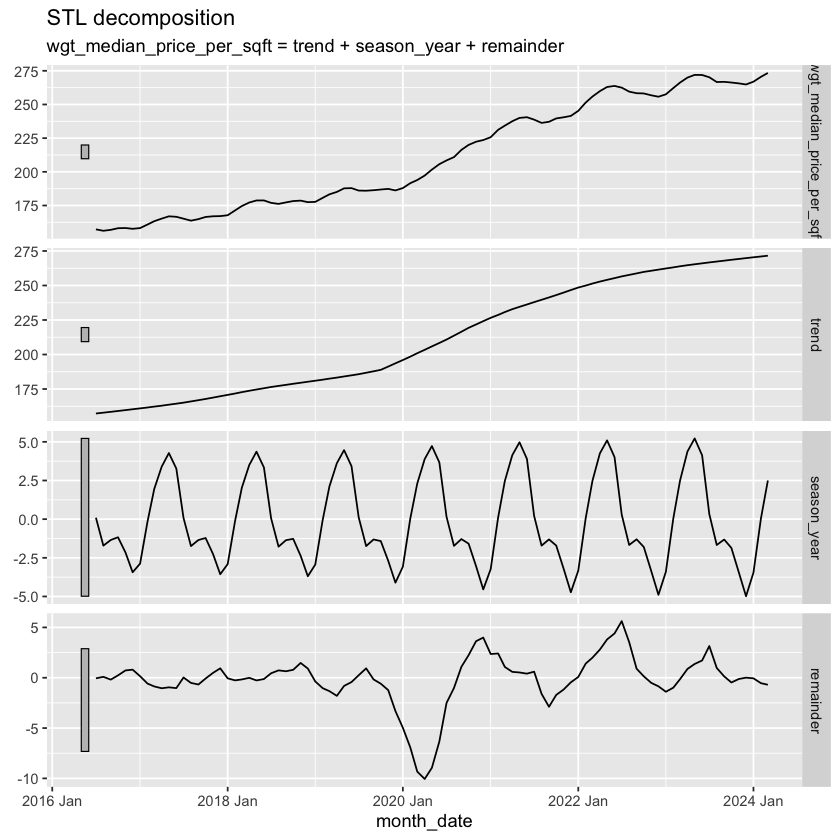

In [ ]:
# Again checking for outliers 
wgt_median_price_per_sqft_decomp <- wgt_median_price_per_sqft_fill |>
  model(
    stl = STL(wgt_median_price_per_sqft , robust = TRUE)
  ) |>
  components()
wgt_median_price_per_sqft_decomp |> autoplot()

In [ ]:
outliers <- wgt_median_price_per_sqft_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_price_per_sqft trend    season_year remainder 
1 stl    2020 Feb   191.5721                  198.4604 0.03926365   -6.927547
2 stl    2020 Mar   193.9051                  200.9294 2.30270846   -9.326969
3 stl    2020 Apr   197.2274                  203.3984 3.88615636  -10.057141
4 stl    2020 May   201.6537                  205.8753 4.72541467   -8.946985
5 stl    2020 Jun   205.6794                  208.3522 3.66938565   -6.342169
  season_adjust
1 191.5328     
2 191.6024     
3 193.3412     
4 196.9283     
5 202.0100

Again found the 5 outliers, repeating the same process again.

In [ ]:
wgt_median_price_per_sqft_fill <- wgt_median_price_per_sqft_fill |>
  select(wgt_median_price_per_sqft) %>%
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

wgt_median_price_per_sqft_fill %>% filter_index('2020 Feb' ~ '2020 Jun')

Joining with `by = join_by(wgt_median_price_per_sqft, month_date)`


wgt_median_price_per_sqft month_date
1 NA                        2020 Feb  
2 NA                        2020 Mar  
3 NA                        2020 Apr  
4 NA                        2020 May  
5 NA                        2020 Jun

In [ ]:
wgt_median_price_per_sqft_fill <- wgt_median_price_per_sqft_fill |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(wgt_median_price_per_sqft)) |>
  # Estimate missing for all periods
  interpolate(wgt_median_price_per_sqft_fill)

wgt_median_price_per_sqft_fill %>% filter_index('2020 Feb' ~ '2020 Jun')

month_date wgt_median_price_per_sqft
1 2020 Feb   192.5363                 
2 2020 Mar   196.5093                 
3 2020 Apr   200.9606                 
4 2020 May   206.1501                 
5 2020 Jun   209.6610

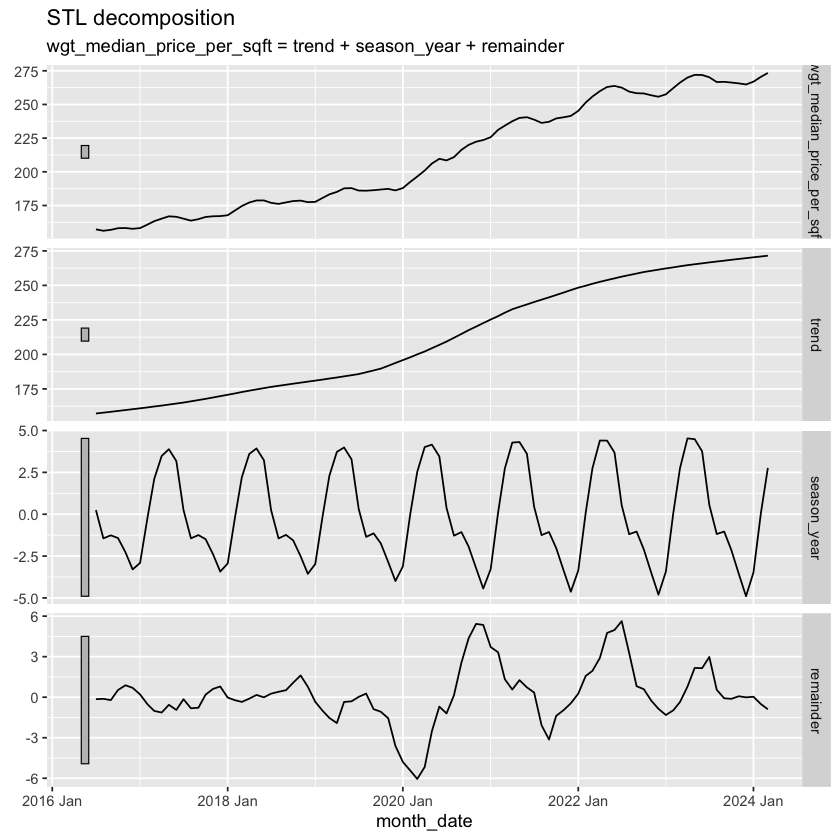

In [ ]:
# Checking for the outliers
wgt_median_price_per_sqft_decomp <- wgt_median_price_per_sqft_fill |>
  model(
    stl = STL(wgt_median_price_per_sqft , robust = TRUE)
  ) |>
  components()
wgt_median_price_per_sqft_decomp |> autoplot()

In [ ]:
outliers <- wgt_median_price_per_sqft_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_price_per_sqft trend    season_year remainder
1 stl    2020 Mar   196.5093                  200.0276 2.532719    -6.051047
  season_adjust
1 193.9766

Found only one outlier, lets try to replace with interpolation

In [ ]:
wgt_median_price_per_sqft_fill <- wgt_median_price_per_sqft_fill |>
  select(wgt_median_price_per_sqft) %>%
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

wgt_median_price_per_sqft_fill %>% filter_index('2020 Feb' ~ '2020 Jun')

Joining with `by = join_by(wgt_median_price_per_sqft, month_date)`


wgt_median_price_per_sqft month_date
1 192.5363                  2020 Feb  
2       NA                  2020 Mar  
3 200.9606                  2020 Apr  
4 206.1501                  2020 May  
5 209.6610                  2020 Jun

In [ ]:
wgt_median_price_per_sqft_fill <- wgt_median_price_per_sqft_fill |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(wgt_median_price_per_sqft)) |>
  # Estimate missing values for all periods
  interpolate(wgt_median_price_per_sqft_fill)

wgt_median_price_per_sqft_fill %>% filter_index('2020 Feb' ~ '2020 Jun')

month_date wgt_median_price_per_sqft
1 2020 Feb   192.5363                 
2 2020 Mar   196.6302                 
3 2020 Apr   200.9606                 
4 2020 May   206.1501                 
5 2020 Jun   209.6610

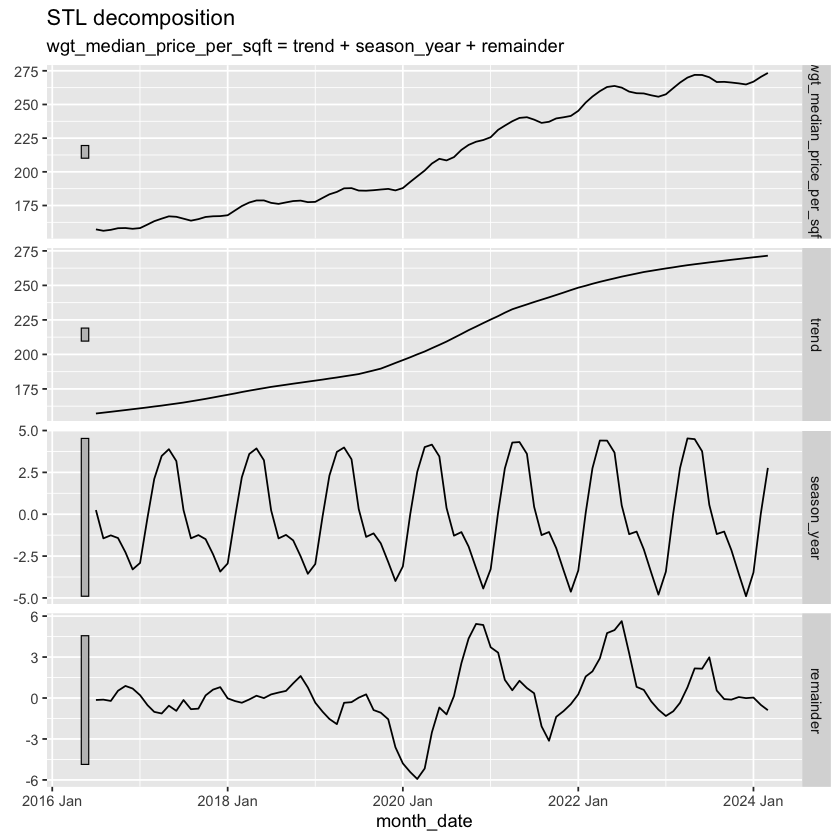

In [ ]:
wgt_median_price_per_sqft_decomp <- wgt_median_price_per_sqft_fill |>
  model(
    stl = STL(wgt_median_price_per_sqft , robust = TRUE)
  ) |>
  components()
wgt_median_price_per_sqft_decomp |> autoplot()

In [ ]:
outliers <- wgt_median_price_per_sqft_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

.model month_date wgt_median_price_per_sqft trend    season_year remainder
1 stl    2020 Mar   196.6302                  200.0277 2.532711    -5.930244
  season_adjust
1 194.0975

Again found the outlier in March 2020 with small change, let's move for modelling further.

## Checking the Count of all metrics after replacing the outliers

In [ ]:
print(paste('Total_listings:', dim(total_listings_fill)[1]))
print(paste('New_listings:', dim(new_listings_fill)[1]))
print(paste('Wt_median_sqft_listings:', dim(wgt_median_square_feet_fill)[1]))
print(paste('Wt_median_price_per_sqft:', dim(wgt_median_price_per_sqft_fill)[1]))

[1] "Total_listings: 93"
[1] "New_listings: 93"
[1] "Wt_median_sqft_listings: 93"
[1] "Wt_median_price_per_sqft: 93"


In [ ]:
total_listings_fill %>% tail(10)

month_date total_listings
1  2023 Jun   1152470       
2  2023 Jul   1265929       
3  2023 Aug   1258923       
4  2023 Sep   1173058       
5  2023 Oct   1113692       
6  2023 Nov   1104433       
7  2023 Dec   1026885       
8  2024 Jan    971218       
9  2024 Feb   1026086       
10 2024 Mar   1106056

All the metrics are having equal counts with 93. Lets proceed for Splitting then training.

## Splitting into Train and test data

In [ ]:
# Splitting the data in almost 80-20
total_listings_tr <- total_listings_fill |> filter_index(. ~ '2022 Dec')
total_listings_ts <- total_listings_fill |> filter_index('2023 Jan' ~ .)

new_listings_tr <- new_listings_fill |> filter_index(. ~ '2022 Dec')
new_listings_ts <- new_listings_fill |> filter_index('2023 Jan' ~ .)

wgt_median_square_feet_tr <- wgt_median_square_feet_fill |> filter_index(. ~ '2022 Dec')
wgt_median_square_feet_ts <- wgt_median_square_feet_fill |> filter_index('2023 Jan' ~ .)

wgt_median_price_per_sqft_tr <- wgt_median_price_per_sqft_fill |> filter_index(. ~ '2022 Dec')
wgt_median_price_per_sqft_ts <- wgt_median_price_per_sqft_fill |> filter_index('2023 Jan' ~ .)

Now the Splitting part is done lets do modelling and forecasting one metric at a time.

### Total Listings

In [ ]:
total_listings_tr %>% head(5)

month_date total_listings
1 2016 Jul   1873362       
2 2016 Aug   1845212       
3 2016 Sep   1809143       
4 2016 Oct   1753435       
5 2016 Nov   1664952

In [ ]:
# Creating various models to see which performs best
total_listings_models <- total_listings_tr |>
            model('ETS' = ETS(total_listings), 
                  'ARIMA' = ARIMA(total_listings), 
                  'Naive' = NAIVE(total_listings),
                  'SNAIVE' = SNAIVE(total_listings ~ lag('1 year')),
                  'Seasonal Trend' = TSLM(total_listings ~ trend() + season()) ) 

total_listings_models |> accuracy() |> select(.model, RMSE, MAPE)

.model         RMSE      MAPE     
1 ETS             22247.09  1.288297
2 ARIMA           21707.71  1.072474
3 Naive           70384.53  4.505059
4 SNAIVE         161546.73 10.769156
5 Seasonal Trend  86512.93  5.569207

In the total listings modelling, ARIMA model is having the least score, followed by ETS with small change. Seasonal Naive and Seasonal trend having high RMSE.

In [ ]:
total_listings_models

ETS          ARIMA                              Naive   SNAIVE  
1 <ETS(A,A,A)> <ARIMA(1,0,1)(2,1,0)[12] w/ drift> <NAIVE> <SNAIVE>
  Seasonal Trend
1 <TSLM>

Here we can see that  SARIMA model with (p,d,q) = (1,0,1) and (P,D,Q) = (2,1,0) is suggested by Auto ARIMA.

In [ ]:
total_listings_models |> select(ARIMA) |> report() 

Series: total_listings 
Model: ARIMA(1,0,1)(2,1,0)[12] w/ drift 

Coefficients:
         ar1     ma1     sar1     sar2    constant
      0.9435  0.4349  -0.4798  -0.4338  -11361.892
s.e.  0.0383  0.1079   0.1229   0.1252    3778.089

sigma^2 estimated as 602549853:  log likelihood=-762.64
AIC=1537.27   AICc=1538.7   BIC=1550.41


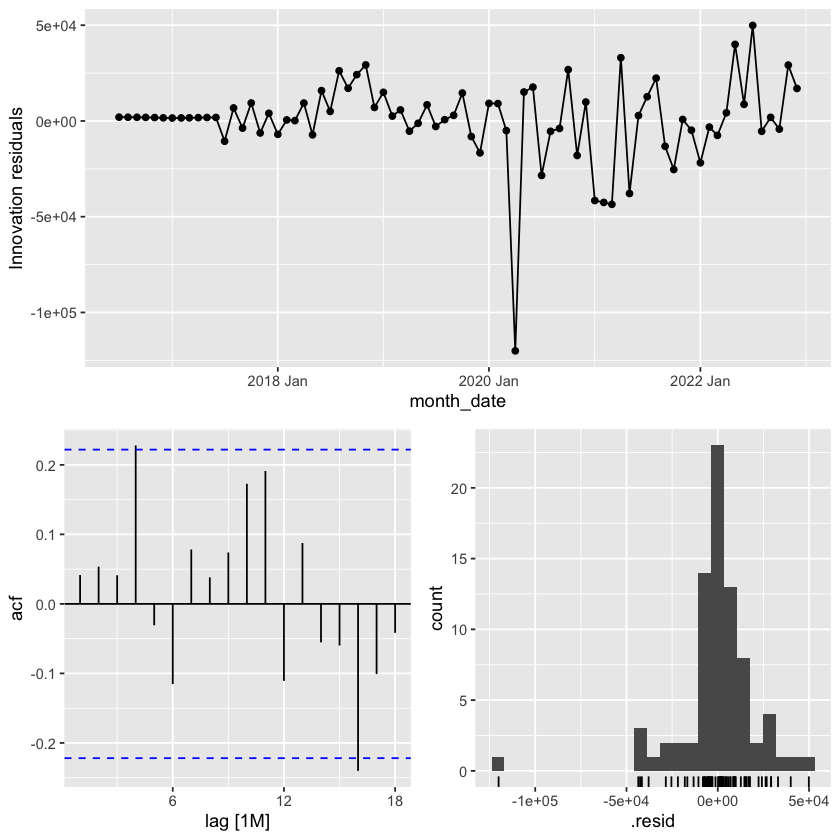

In [ ]:
total_listings_models |> select('ARIMA') |> gg_tsresiduals()

In [ ]:
total_listings_models |> select(ETS) |> report() 

Series: total_listings 
Model: ETS(A,A,A) 
  Smoothing parameters:
    alpha = 0.9998991 
    beta  = 0.1339824 
    gamma = 0.0001006476 

  Initial states:
    l[0]      b[0]     s[0]    s[-1]     s[-2]     s[-3]     s[-4]     s[-5]
 1796958 -8189.192 94378.41 35447.01 -40818.44 -97383.47 -160424.9 -208152.7
     s[-6]    s[-7]    s[-8]    s[-9]   s[-10]   s[-11]
 -96199.52 33408.29 96471.39 109413.9 119705.1 114154.9

  sigma^2:  622657810

     AIC     AICc      BIC 
1935.378 1945.578 1975.442 


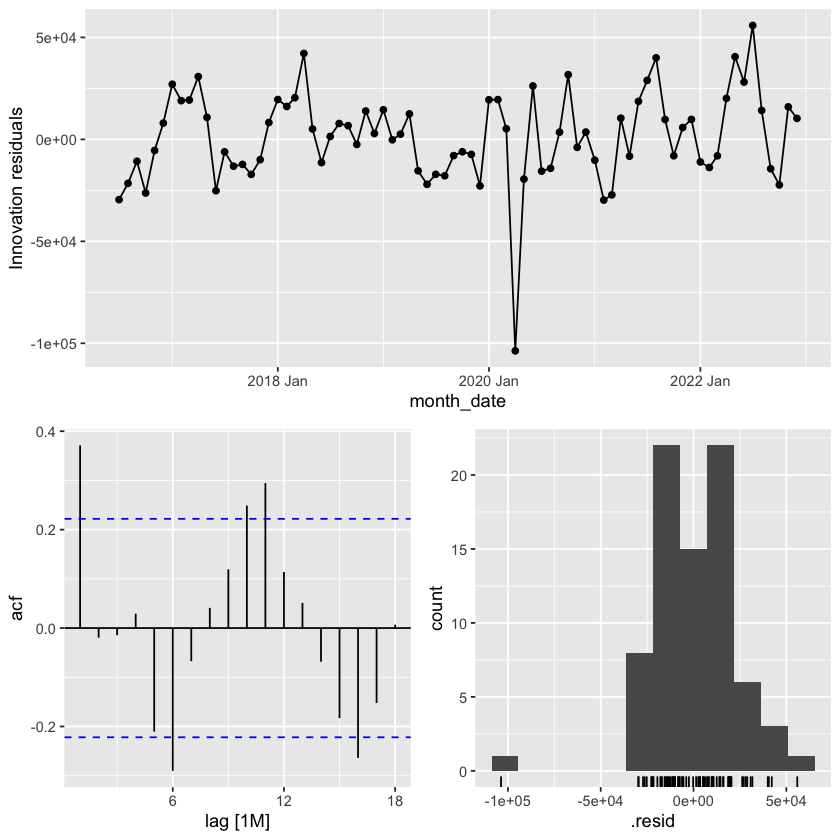

In [ ]:
total_listings_models |> select('ETS') |> gg_tsresiduals()

From the above reports and residual plots, AICc is lesser for ARIMA model and more acf lags are in the confidence interval for ARIMA model.

#### Evaluating the models with test data

In [ ]:
total_listings_models_test <- total_listings_models |>
forecast(total_listings_ts) 

total_listings_models_test |> accuracy(total_listings_ts) |> select(.model, RMSE, MAPE)

.model         RMSE      MAPE     
1 ARIMA          136873.09  9.429249
2 ETS             59121.19  4.799718
3 Naive          131111.03  9.009836
4 SNAIVE         104151.15  7.713586
5 Seasonal Trend 199708.72 16.544187

Unlike the train data, ETS model is performing better with test data. So let's plot the test predictions with actual data.

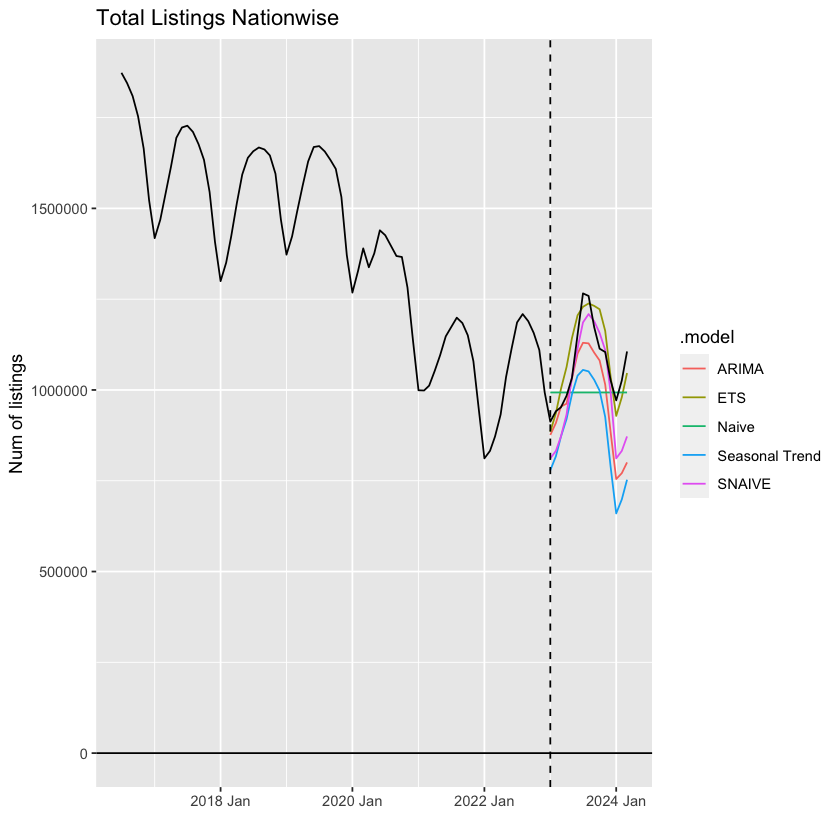

In [ ]:
total_listings_models_test |> autoplot(level=NULL) +
autolayer(total_listings_fill, total_listings) +
labs(title='Total Listings Nationwise', x='', y='Num of listings') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0)

In the above plot, ETS forecast is more similar to the actual test values. So forecasting further with ETS model.

#### Out of Sample Forecasting of Total listings

In [ ]:
total_listings_models_fnl <- total_listings_fill |>
model(
    'ETS' = ETS(total_listings)
)

total_listings_models_fnl %>% report()

Series: total_listings 
Model: ETS(A,Ad,A) 
  Smoothing parameters:
    alpha = 0.9998898 
    beta  = 0.1324862 
    gamma = 0.0001063131 
    phi   = 0.8923151 

  Initial states:
    l[0]      b[0]     s[0]    s[-1]     s[-2]    s[-3]     s[-4]     s[-5]
 1793929 -8506.943 90360.94 23003.11 -49725.45 -96077.5 -155801.9 -202717.2
     s[-6]    s[-7]    s[-8]    s[-9]   s[-10]   s[-11]
 -93977.94 33783.42 94508.39 106838.8 131807.2 117998.1

  sigma^2:  924750075

     AIC     AICc      BIC 
2358.746 2367.990 2404.333 


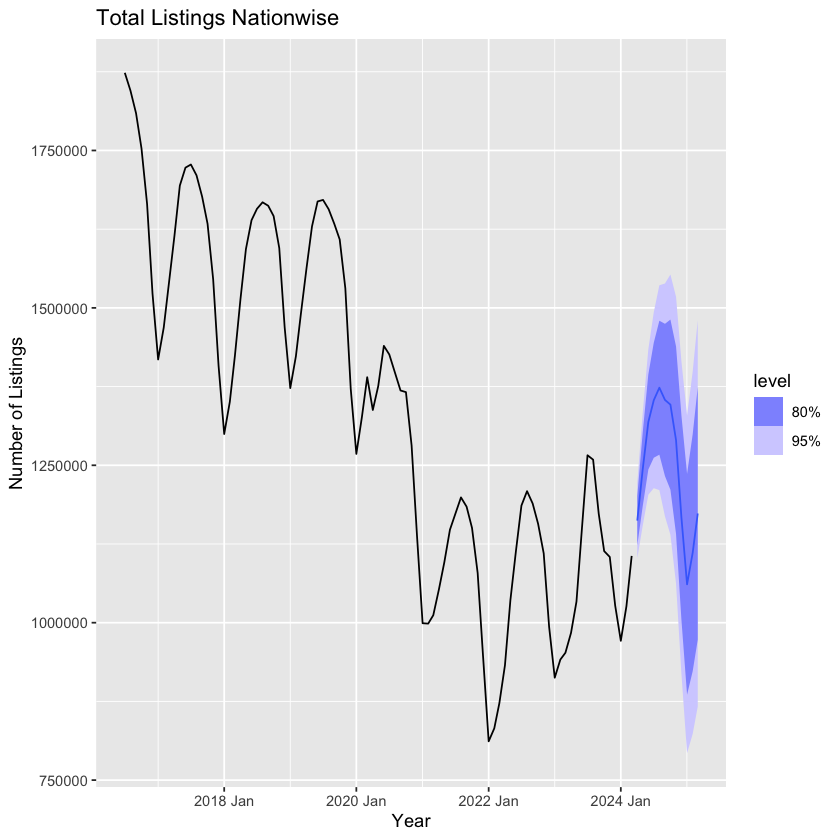

In [ ]:
total_listings_models_fnl |> forecast(h=12) |>
autoplot() + 
autolayer(total_listings_fill, total_listings) +
labs(title='Total Listings Nationwise', x='Year', y='Number of Listings')

Total Listings forecast for next 12 months is as above and the values of the forecast is computed below.

In [ ]:
total_listings_models_fnl_values <- total_listings_fill %>%
model(
    'ETS' = ETS(total_listings)
)|>
forecast(h = 12) |>
as.data.frame() |>
select(month_date, .mean) |>
rename(total_listings = .mean) |>
as_tsibble(index=month_date)

total_listings_models_fnl_values

month_date total_listings
1  2024 Apr   1162156       
2  2024 May   1243571       
3  2024 Jun   1318685       
4  2024 Jul   1353247       
5  2024 Aug   1373216       
6  2024 Sep   1353770       
7  2024 Oct   1346343       
8  2024 Nov   1290022       
9  2024 Dec   1166176       
10 2025 Jan   1060936       
11 2025 Feb   1110956       
12 2025 Mar   1173462

### New_listings

In [ ]:
# Checking various models to see which performs best
new_listings_models <- new_listings_tr |>
            model('ETS' = ETS(new_listings), 
                  'ARIMA' = ARIMA(new_listings),
                  'NAIVE' = NAIVE(new_listings),
                  'SNAIVE' = SNAIVE(new_listings ~ lag('1 year')),
                  'Seasonal Trend' = TSLM(new_listings ~ trend() + season()) ) #|>
                  #'prophet' = prophet(total_listings ~ season(period = 1, order = 2, type = "additive"))) |>
            #reconcile(bu = bottom_up(ARIMA), MinT = min_trace(ARIMA, method = "mint_shrink"))

new_listings_models |> accuracy() |> select(.model, RMSE, MAPE)

.model         RMSE     MAPE     
1 ETS            14978.16  2.799151
2 ARIMA          15668.53  2.652299
3 NAIVE          53309.56 12.055593
4 SNAIVE         27855.60  5.336529
5 Seasonal Trend 19606.88  3.967786

In [ ]:
new_listings_models

ETS          ARIMA                     NAIVE   SNAIVE   Seasonal Trend
1 <ETS(A,N,A)> <ARIMA(0,1,2)(0,1,1)[12]> <NAIVE> <SNAIVE> <TSLM>

On the trained data ETS model is performing slightly better than the ARIMA model with (p,d,q) = (0,1,2) and (P,D,Q) = (0,1,1)

In [ ]:
new_listings_models |> select(ARIMA) |> report() 

Series: new_listings 
Model: ARIMA(0,1,2)(0,1,1)[12] 

Coefficients:
          ma1      ma2     sma1
      -0.1508  -0.3686  -0.4339
s.e.   0.1251   0.1353   0.1709

sigma^2 estimated as 308858402:  log likelihood=-727.45
AIC=1462.89   AICc=1463.56   BIC=1471.59


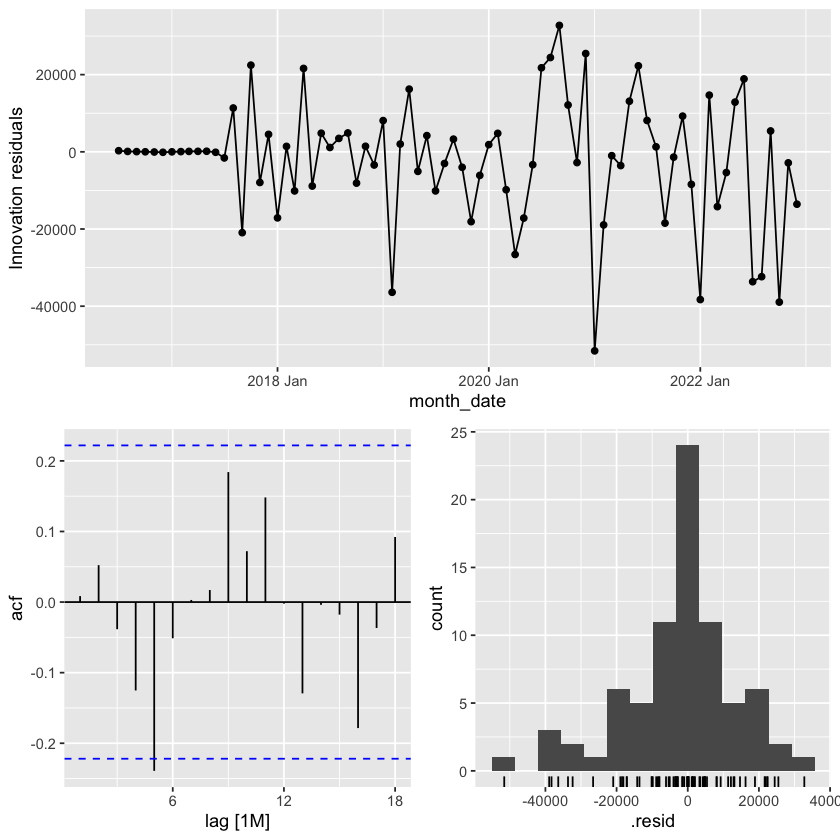

In [ ]:
new_listings_models |> select('ARIMA') |> gg_tsresiduals()

In [ ]:
new_listings_models |> select(ETS) |> report() 

Series: new_listings 
Model: ETS(A,N,A) 
  Smoothing parameters:
    alpha = 0.8755207 
    gamma = 0.0001000072 

  Initial states:
     l[0]     s[0]  s[-1]    s[-2]    s[-3]     s[-4]     s[-5]     s[-6]
 449989.8 87478.11 103596 75263.01 26238.86 -42404.32 -89282.43 -167412.6
     s[-7]    s[-8]    s[-9]   s[-10] s[-11]
 -83781.39 -14416.3 10163.83 39510.19  55047

  sigma^2:  273420628

     AIC     AICc      BIC 
1869.662 1877.404 1905.012 


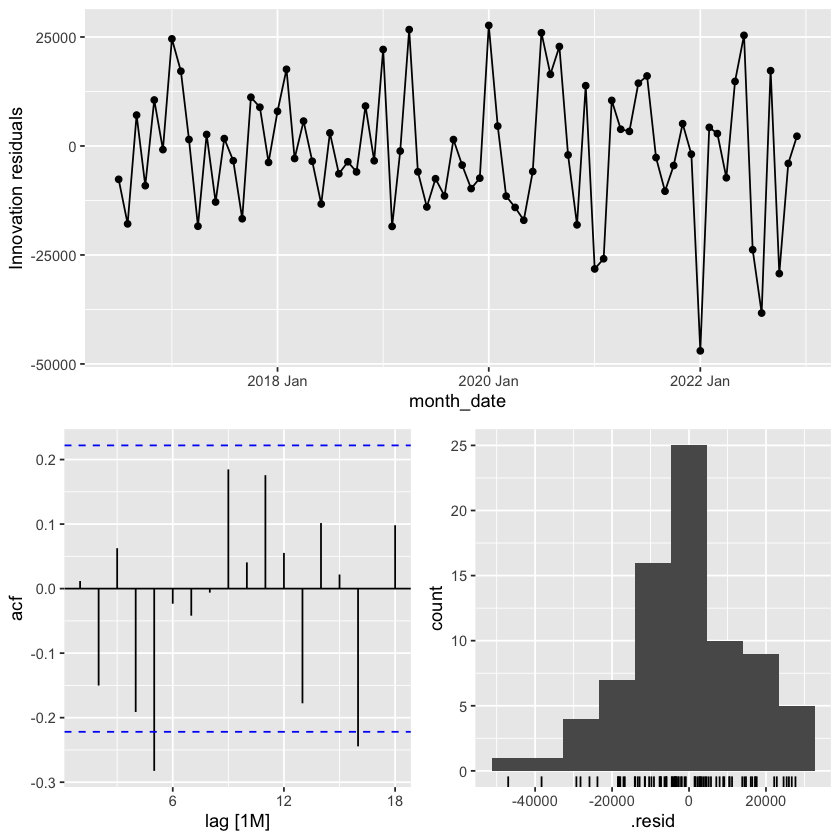

In [ ]:
new_listings_models |> select('ETS') |> gg_tsresiduals()

As per the above reports and residual plots, ETS is having more AICc and it is having more acf lags outside the confidence interval than ARIMA. Residuals are more normally distributed in ETS than ARIMA.

#### Evaluating the model on test data

In [ ]:
new_listings_models_test <- new_listings_models |>
forecast(new_listings_ts) 

new_listings_models_test |> accuracy(new_listings_ts) |> select(.model, RMSE, MAPE)

.model         RMSE      MAPE     
1 ARIMA           39139.69 10.648939
2 ETS             31545.58  7.362355
3 NAIVE          150253.85 38.984456
4 SNAIVE          61577.30 14.660720
5 Seasonal Trend  67493.77 17.411712

Like in trained data performance, ETS model is performing in Test data as well. Lets check the forecast plot of test data with all models.

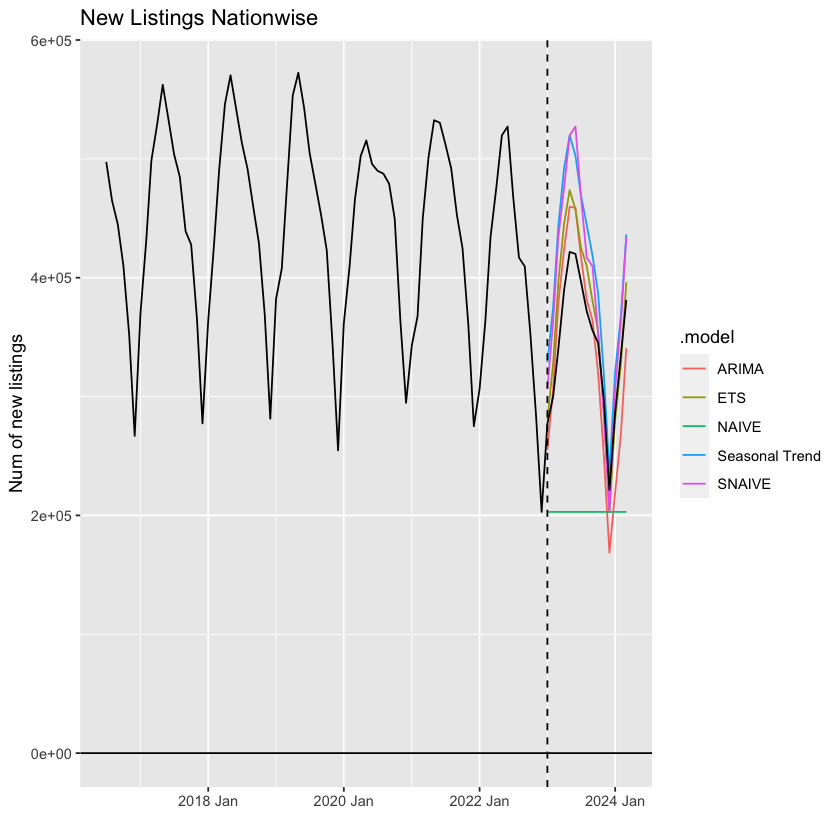

In [ ]:
new_listings_models_test |> autoplot(level=NULL) +
autolayer(new_listings_fill, new_listings) +
labs(title='New Listings Nationwise', x='', y='Num of new listings') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0)

ETS model plot is more sync with the actual test data. Lets use the same model for further forecasting.

#### Out of Sample Forecasting of New listings

In [ ]:
new_listings_models_fnl <- new_listings_fill |>
model(
    'ETS' = ETS(new_listings)
)

new_listings_models_fnl %>% report()

Series: new_listings 
Model: ETS(A,N,A) 
  Smoothing parameters:
    alpha = 0.9998823 
    gamma = 0.0001000501 

  Initial states:
     l[0]     s[0]    s[-1]    s[-2]    s[-3]     s[-4]     s[-5]     s[-6]
 449990.5 87108.15 101549.7 73199.16 22972.24 -42559.71 -86931.73 -164699.8
     s[-7]     s[-8]    s[-9]   s[-10]   s[-11]
 -82950.04 -14804.44 12580.64 36399.89 58135.92

  sigma^2:  250089229

     AIC     AICc      BIC 
2234.730 2240.964 2272.719 


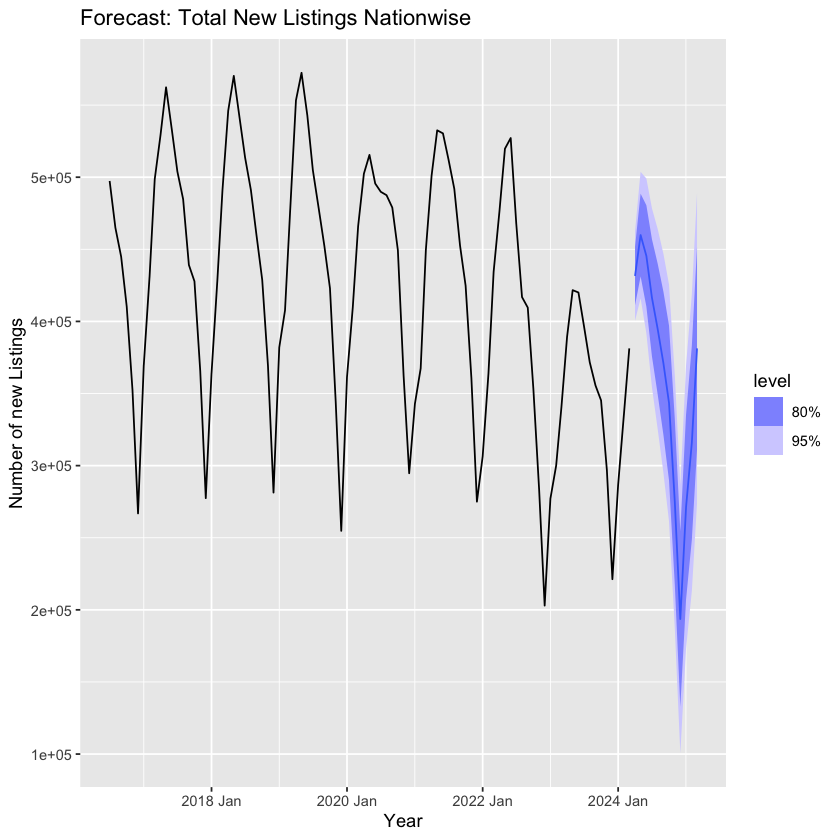

In [ ]:
new_listings_models_fnl |> forecast(h=12) |>
autoplot() + 
autolayer(new_listings_fill, new_listings) +
labs(title='Forecast: Total New Listings Nationwise', x='Year', y='Number of new Listings')

In [ ]:
new_listings_models_fnl_values <- new_listings_fill %>%
model(
    'ETS' = ETS(new_listings)
)|>
forecast(h = 12) |>
as.data.frame() |>
select(month_date, .mean) |>
rename(total_listings = .mean) |>
as_tsibble(index=month_date)

new_listings_models_fnl_values

month_date total_listings
1  2024 Apr   431530.8      
2  2024 May   459882.4      
3  2024 Jun   445440.7      
4  2024 Jul   416467.8      
5  2024 Aug   394730.3      
6  2024 Sep   370913.0      
7  2024 Oct   343527.4      
8  2024 Nov   275384.7      
9  2024 Dec   193632.1      
10 2025 Jan   271400.5      
11 2025 Feb   315772.7      
12 2025 Mar   381302.3

### Median Square Feet

In [ ]:
# Checking various models to see which performs best
med_sq_ft_models <- wgt_median_square_feet_tr |>
            model('ETS' = ETS(wgt_median_square_feet), 
                  'ARIMA' = ARIMA(wgt_median_square_feet), 
                  'NAIVE' = NAIVE(wgt_median_square_feet),
                  'SNAIVE' = SNAIVE(wgt_median_square_feet ~ lag('1 year')),
                  'Seasonal Trend' = TSLM(wgt_median_square_feet ~ trend() + season()) ) 

med_sq_ft_models |> accuracy() |> select(.model, RMSE, MAPE)

.model         RMSE      MAPE     
1 ETS             8.344670 0.3146365
2 ARIMA           6.973181 0.2413597
3 NAIVE          15.624530 0.6962149
4 SNAIVE         53.011286 2.0134035
5 Seasonal Trend 36.242100 1.6336285

With Median Square feet, ARIMA model is having less RMSE which is performing better than any other model.

In [ ]:
med_sq_ft_models

ETS          ARIMA                     NAIVE   SNAIVE   Seasonal Trend
1 <ETS(M,N,A)> <ARIMA(2,0,0)(2,1,0)[12]> <NAIVE> <SNAIVE> <TSLM>

ARIMA with (p,d,q)=(2,0,0) and (P,D,Q)=(2,1,0) is having better performance.

In [ ]:
med_sq_ft_models |> select(ARIMA) |> report() 

Series: wgt_median_square_feet 
Model: ARIMA(2,0,0)(2,1,0)[12] 

Coefficients:
         ar1      ar2    sar1     sar2
      1.5123  -0.5279  -0.678  -0.4325
s.e.  0.1028   0.1023   0.116   0.1250

sigma^2 estimated as 61.17:  log likelihood=-232.72
AIC=475.44   AICc=476.44   BIC=486.39


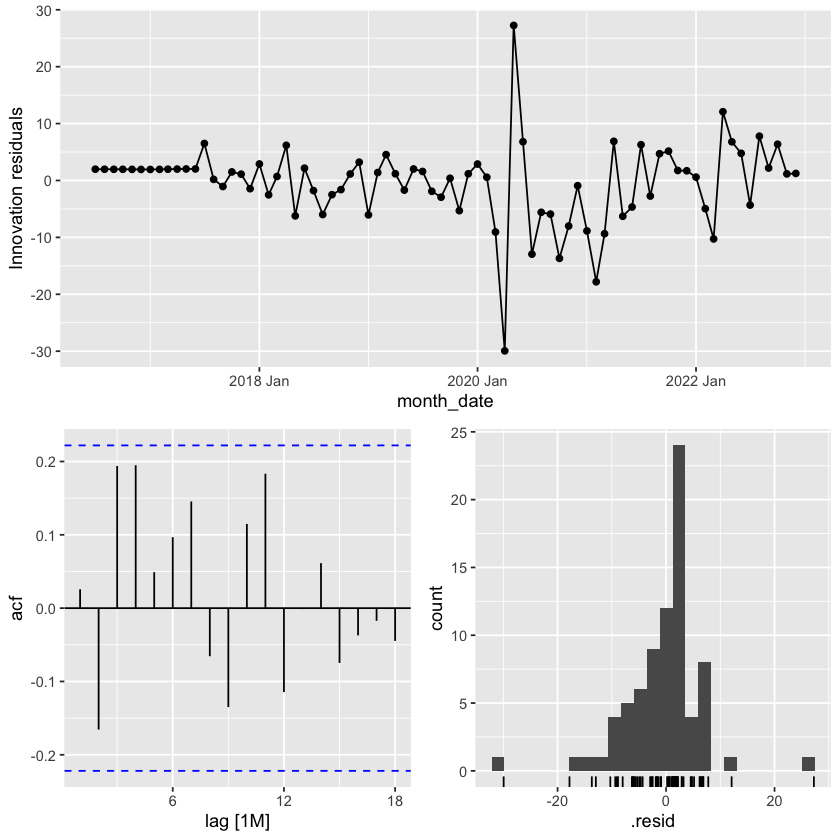

In [ ]:
med_sq_ft_models |> select('ARIMA') |> gg_tsresiduals()

In [ ]:
med_sq_ft_models |> select(ETS) |> report() 

Series: wgt_median_square_feet 
Model: ETS(M,N,A) 
  Smoothing parameters:
    alpha = 0.9996155 
    gamma = 0.0003581226 

  Initial states:
     l[0]     s[0]    s[-1]    s[-2]     s[-3]     s[-4]     s[-5]     s[-6]
 1986.487 37.78306 28.60398 11.17781 -11.90685 -30.90215 -40.17215 -32.16699
     s[-7]     s[-8]    s[-9]   s[-10]   s[-11]
 -15.01156 -2.724941 8.686202 18.25304 28.38055

  sigma^2:  0

     AIC     AICc      BIC 
700.2627 708.0046 735.6133 


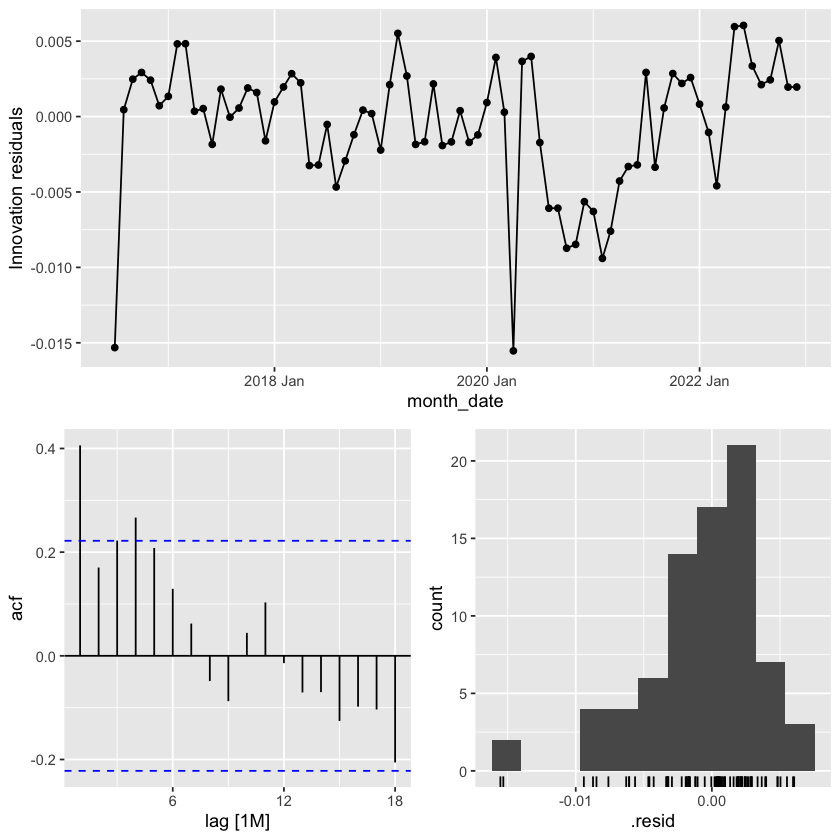

In [ ]:
med_sq_ft_models |> select('ETS') |> gg_tsresiduals()

From the above reports and residual plots, ARIMA is having less AICc and residuals of ARIMA are more like white noise than ETS, lags of ARIMA are within confidence level.

#### Evaluating the models with test data

In [ ]:
med_sq_ft_models_test <- med_sq_ft_models |>
forecast(wgt_median_square_feet_ts) 

med_sq_ft_models_test |> accuracy(wgt_median_square_feet_ts) |> select(.model, RMSE, MAPE)

.model         RMSE      MAPE     
1 ARIMA           7.924414 0.3265100
2 ETS            15.702771 0.5678403
3 NAIVE          40.106946 1.7106888
4 SNAIVE         34.096414 1.5531047
5 Seasonal Trend 44.560022 2.2861706

Even on the test data, ARIMA is performing better because it is having low RMSE.

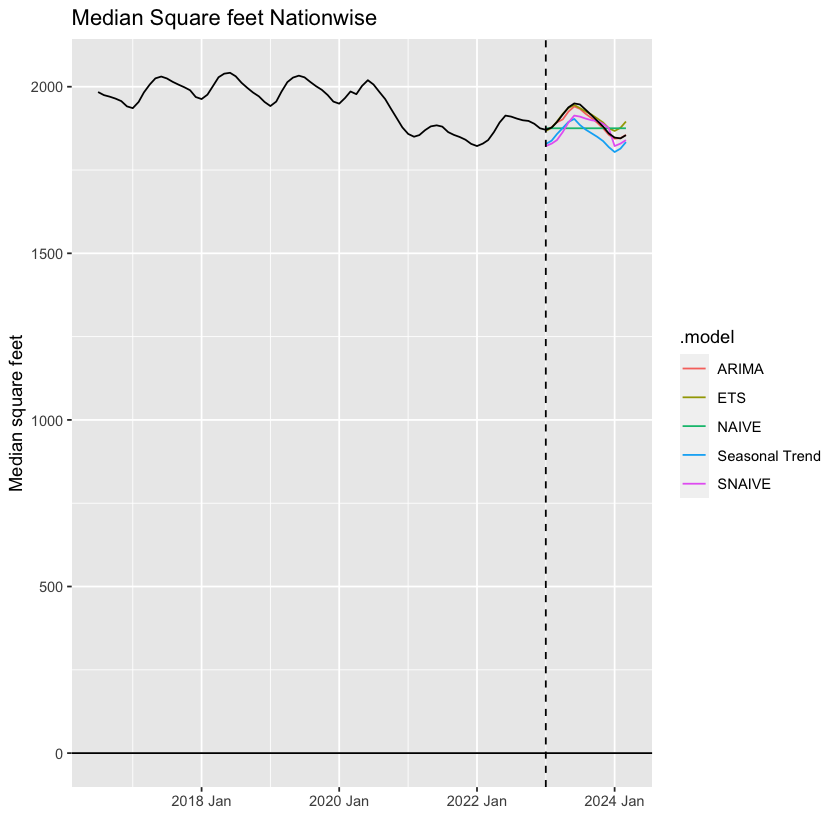

In [ ]:
med_sq_ft_models_test |> autoplot(level=NULL) +
autolayer(wgt_median_square_feet_fill, wgt_median_square_feet) +
labs(title='Median Square feet Nationwise', x='', y='Median square feet') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0)

ARIMA model prediction is more insync with actual test data. So lets use ARIMA model for forecasting.

#### Out of Sample Forecasting of Weighted Median Square feet.

In [ ]:
med_sq_ft_models_fnl <- wgt_median_square_feet_fill |>
model(
    'ARIMA' = ARIMA(wgt_median_square_feet)
)

med_sq_ft_models_fnl %>% report()

Series: wgt_median_square_feet 
Model: ARIMA(2,0,0)(0,1,1)[12] 

Coefficients:
         ar1      ar2     sma1
      1.5264  -0.5343  -0.8703
s.e.  0.0939   0.0920   0.2753

sigma^2 estimated as 46.08:  log likelihood=-277.19
AIC=562.39   AICc=562.91   BIC=571.96


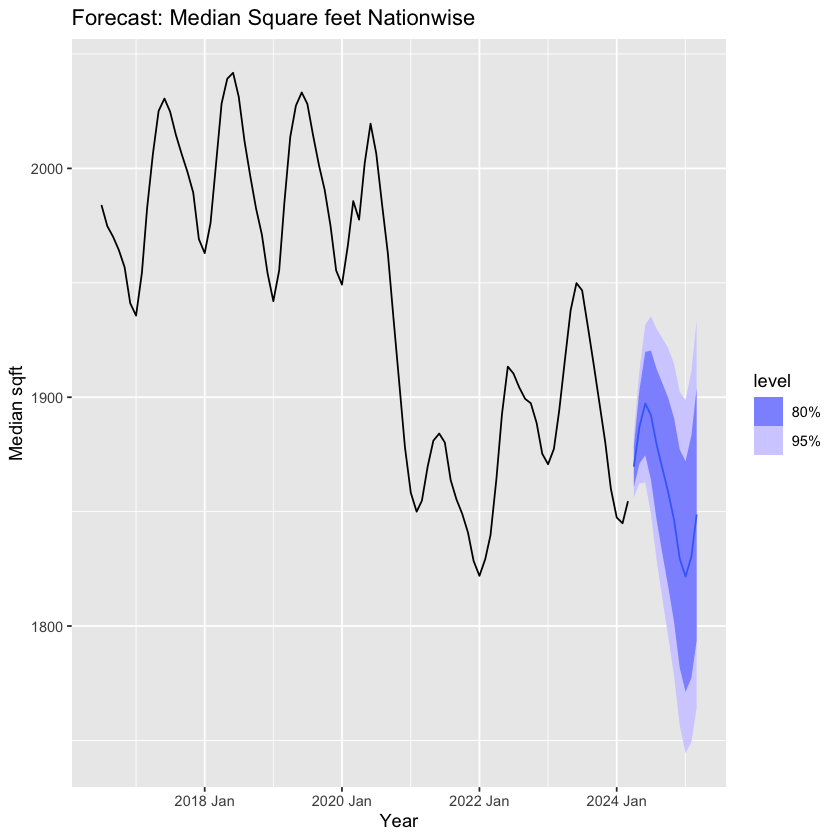

In [ ]:
med_sq_ft_models_fnl |> forecast(h=12) |>
autoplot() + 
autolayer(wgt_median_square_feet_fill, wgt_median_square_feet) +
labs(title='Forecast: Median Square feet Nationwise', x='Year', y='Median sqft')

Plot for the Median Square feet for next 12 months is shown above and its corresponding values are printed in below cell.

In [ ]:
med_sq_ft_models_fnl_values <- wgt_median_square_feet_fill %>%
model(
    'ARIMA' = ARIMA(wgt_median_square_feet)
)|>
forecast(h = 12) |>
as.data.frame() |>
select(month_date, .mean) |>
rename(total_listings = .mean) |>
as_tsibble(index=month_date)

med_sq_ft_models_fnl_values

month_date total_listings
1  2024 Apr   1869.651      
2  2024 May   1887.117      
3  2024 Jun   1897.230      
4  2024 Jul   1892.177      
5  2024 Aug   1878.990      
6  2024 Sep   1868.477      
7  2024 Oct   1858.395      
8  2024 Nov   1846.304      
9  2024 Dec   1829.478      
10 2025 Jan   1821.609      
11 2025 Feb   1830.271      
12 2025 Mar   1848.736

### Weighted Median Price per sqft

In [ ]:
# Creating various models to see which performs best
median_price_per_sqft_models <- wgt_median_price_per_sqft_tr |>
            model('ETS' = ETS(wgt_median_price_per_sqft), 
                  'ARIMA' = ARIMA(wgt_median_price_per_sqft), 
                  'NAIVE' = NAIVE(wgt_median_price_per_sqft),
                  'SNAIVE' = SNAIVE(wgt_median_price_per_sqft ~ lag('1 year')),
                  'Seasonal Trend' = TSLM(wgt_median_price_per_sqft ~ trend() + season()) ) 

median_price_per_sqft_models |> accuracy() |> select(.model, RMSE, MAPE)

.model         RMSE       MAPE     
1 ETS             1.0744061 0.3725223
2 ARIMA           0.9360579 0.3047888
3 NAIVE           2.4203333 0.9404782
4 SNAIVE         19.9260234 8.1690681
5 Seasonal Trend  7.9211941 3.4278345

From the above accuracy report we can say that ARIMA is performing better than any other model because it is having very less RMSE.

In [ ]:
median_price_per_sqft_models

ETS          ARIMA                     NAIVE   SNAIVE   Seasonal Trend
1 <ETS(M,A,A)> <ARIMA(1,1,0)(2,1,0)[12]> <NAIVE> <SNAIVE> <TSLM>

ARIMA model with parameters (p=1,d=1,q=0)(P=2,D=1,Q=0) is suggested by auto ARIMA and is performing better than other models.

In [ ]:
median_price_per_sqft_models |> select(ARIMA) |> report() 

Series: wgt_median_price_per_sqft 
Model: ARIMA(1,1,0)(2,1,0)[12] 

Coefficients:
         ar1     sar1    sar2
      0.7262  -0.4124  -0.360
s.e.  0.0837   0.1224   0.137

sigma^2 estimated as 1.102:  log likelihood=-96.33
AIC=200.66   AICc=201.32   BIC=209.35


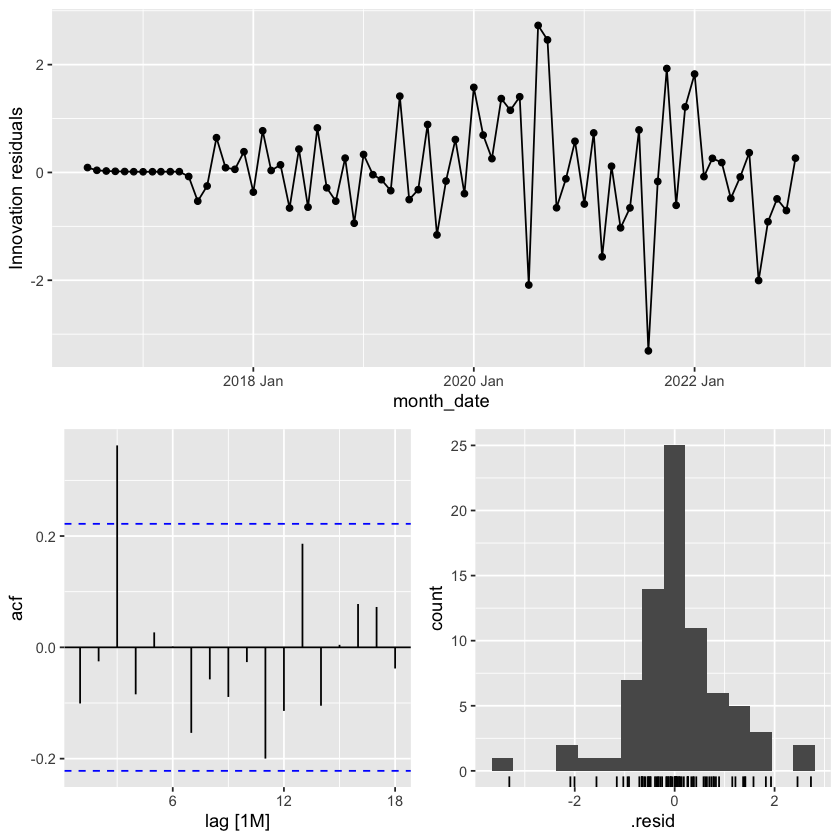

In [ ]:
median_price_per_sqft_models |> select('ARIMA') |> gg_tsresiduals()

In [ ]:
median_price_per_sqft_models |> select(ETS) |> report() 

Series: wgt_median_price_per_sqft 
Model: ETS(M,A,A) 
  Smoothing parameters:
    alpha = 0.9997687 
    beta  = 0.1339923 
    gamma = 0.0001168731 

  Initial states:
     l[0]      b[0]     s[0]    s[-1]    s[-2]   s[-3]      s[-4]    s[-5]
 155.6839 0.8241559 3.837029 4.276477 2.677093 1.13501 -0.9368267 -3.46196
     s[-6]     s[-7]     s[-8]     s[-9]     s[-10]   s[-11]
 -3.473649 -1.990281 -1.209694 -1.118062 -0.8560628 1.120927

  sigma^2:  0

     AIC     AICc      BIC 
369.0951 379.2951 409.1592 


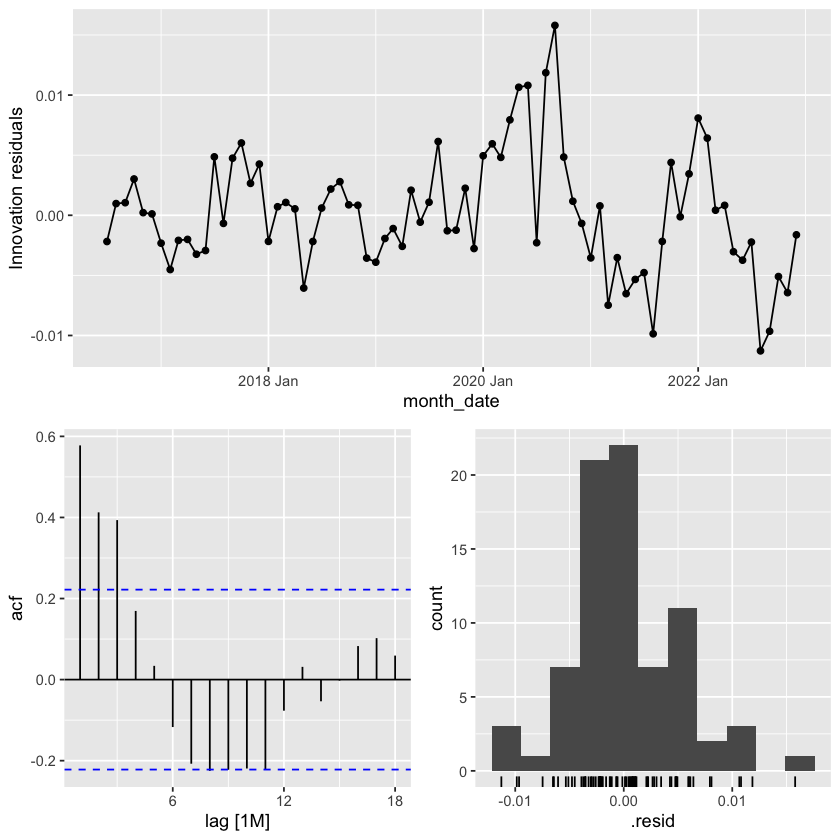

In [ ]:
median_price_per_sqft_models |> select('ETS') |> gg_tsresiduals()

From the above reports and residuals we can see that residuals in ARIMA model are like white noise than the ETS model. Also the ACF lags of ETS are like seasonal, slowly dampening.

#### Evaluating the models on test data

In [ ]:
median_price_per_sqft_models_test <- median_price_per_sqft_models |>
forecast(total_listings_ts) 

median_price_per_sqft_models_test |> accuracy(wgt_median_price_per_sqft_ts) |> select(.model, RMSE, MAPE)

.model         RMSE      MAPE     
1 ARIMA           7.291987 2.1444607
2 ETS             2.687293 0.8028571
3 NAIVE          12.310105 4.3335749
4 SNAIVE         12.027741 4.1900809
5 Seasonal Trend  5.507825 1.6858913

Unlike on the train data, ETS model is performing better on the test data. Lets plot the forecast of the all the models.

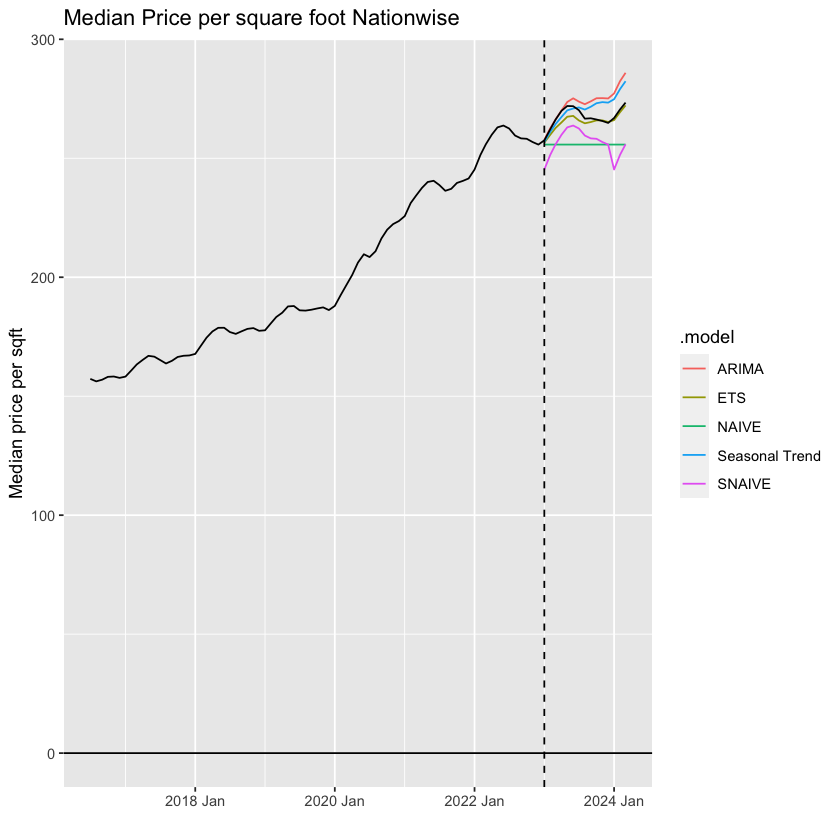

In [ ]:
median_price_per_sqft_models_test |> autoplot(level=NULL) +
autolayer(wgt_median_price_per_sqft_fill, wgt_median_price_per_sqft) +
labs(title='Median Price per square foot Nationwise', x='', y='Median price per sqft') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0)

From the above plot we can see that ETS model is in almost insync with the actual test data. Lets use the ETS model to forecast further for 12 months

In [ ]:
median_price_per_sqft_models_fnl <- wgt_median_price_per_sqft_fill |>
model(
    'ETS' = ETS(wgt_median_price_per_sqft)
)

median_price_per_sqft_models_fnl %>% report()

Series: wgt_median_price_per_sqft 
Model: ETS(M,A,A) 
  Smoothing parameters:
    alpha = 0.999871 
    beta  = 0.1339794 
    gamma = 0.0001172615 

  Initial states:
     l[0]      b[0]     s[0]    s[-1]    s[-2]    s[-3]      s[-4]     s[-5]
 156.0583 0.8149719 3.773217 4.693471 3.215591 1.506836 -0.4517567 -3.272085
     s[-6]     s[-7]     s[-8]     s[-9]    s[-10]    s[-11]
 -3.585604 -2.127183 -1.310949 -1.513122 -1.579253 0.6508385

  sigma^2:  0

     AIC     AICc      BIC 
452.6346 460.7946 495.6888 


#### Out of Sample Forecasting of Weight Median Price per Square feet.

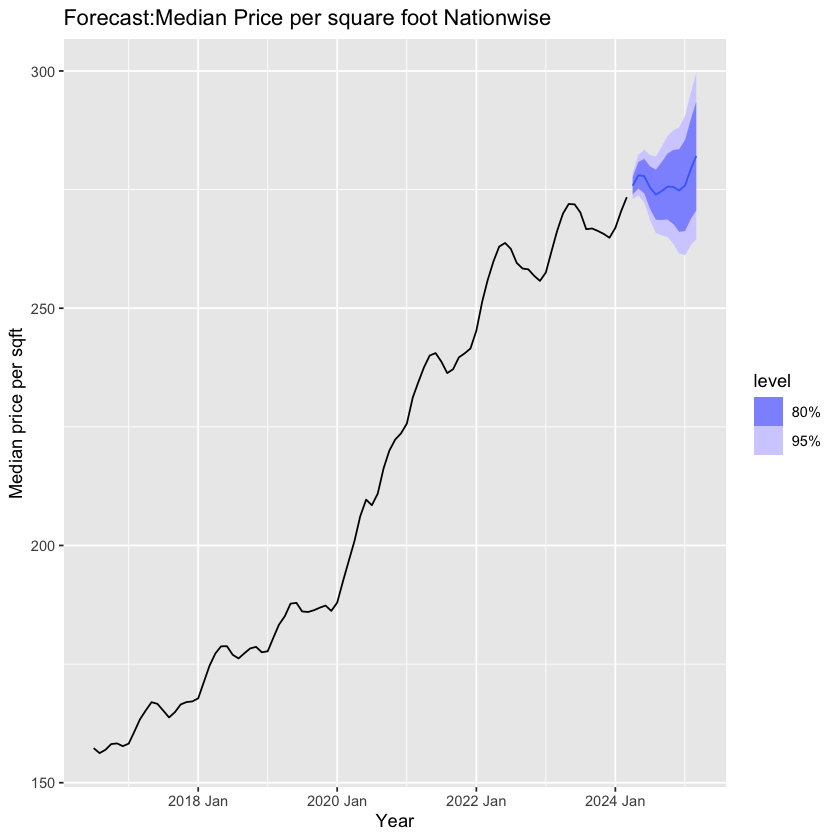

In [ ]:
median_price_per_sqft_models_fnl |> forecast(h=12) |>
autoplot() + 
autolayer(wgt_median_price_per_sqft_fill, wgt_median_price_per_sqft) +
labs(title='Forecast:Median Price per square foot Nationwise', x='Year', y='Median price per sqft')

In [ ]:
median_price_per_sqft_models_fnl_values <- wgt_median_price_per_sqft_fill %>%
model(
    'ETS' = ETS(wgt_median_price_per_sqft)
)|>
forecast(h = 12) |>
as.data.frame() |>
select(month_date, .mean) |>
rename(total_listings = .mean) |>
as_tsibble(index=month_date)

median_price_per_sqft_models_fnl_values

month_date total_listings
1  2024 Apr   275.8263      
2  2024 May   278.0272      
3  2024 Jun   277.8305      
4  2024 Jul   275.4313      
5  2024 Aug   273.9239      
6  2024 Sep   274.7133      
7  2024 Oct   275.6388      
8  2024 Nov   275.5459      
9  2024 Dec   274.8107      
10 2025 Jan   275.8475      
11 2025 Feb   279.3911      
12 2025 Mar   282.0729

Using the ETS model, median price per sqft are successfully forecasted for next 24 months.


In this project, both Exponential Smoothing and ARIMA models show nearly identical performance across various metrics, as indicated by the minimal difference in RMSE between them. Consequently, either of these models can effectively forecast each metric.

The initial shutdown during the early stages of the Covid pandemic, around March 2020, significantly impacted the trend of all metrics. For instance, metrics like the median square footage have yet to return to their pre-Covid levels, suggesting a preference among many individuals for selling smaller properties.

Conversely, the median price per square foot experienced a notable increase during the Covid period and has sustained its growth. This upward trend in price might be influencing more people to opt for smaller houses due to budget constraints.